# Combine IDOC population data sets

IDOC publishes population data sets which consist of each person housed in a state prison each quarter and information about them, such as their demographics, the type of crime they're being held for, the date on which they were apprehended, etc. The data sets are .xls files, but the titles, URLs, and data within each data set differ and need to be cleaned. This script combines all population data sets and makes the information within them consistent.

The population data sets can be found here: https://www2.illinois.gov/idoc/reportsandstatistics/Pages/Prison-Population-Data-Sets.aspx

This was last updated with the Dec 2021 data set as the most recently published data set.

In [1]:
import calendar
import warnings
from datetime import datetime as dt, date, timedelta as td

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import requests
from bs4 import BeautifulSoup
import xlrd

%matplotlib inline
inline_rc = dict(mpl.rcParams)

pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# helper function to get list of hex codes from tableau 20 pallette
def get_hex(n):
    cmap = cm.get_cmap('tab20', n)
    return [mcolors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]

# helper function to get rgb code from hex code
def get_rgb_from_hex(hex_code):
    hex_code = hex_code.lstrip('#')
    return tuple(int(hex_code[i:i+2], 16) for i in (0, 2, 4))


Get links to the population data sets from the IDOC site.

In [3]:
#updated February 6, 2026 to account for the new format of the links on teh IDOC website.
# The links are now in the format of "https://idoc.illinois.gov/content/dam/soi/en/web/idoc/reportsandstatistics/prison-population-data-sets/2025/2025-01.xlsx" instead of "https://idoc.illinois.gov/reportsandstatistics/prison-population-data-sets/2025-01.xlsx". The code now uses the urljoin function to join the base URL with the relative URL of the Excel files.
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin
import re
import pandas as pd

PAGE_URL = "https://idoc.illinois.gov/reportsandstatistics/prison-population-data-sets.html"

response = requests.get(PAGE_URL, timeout=60)
response.raise_for_status()

soup = BeautifulSoup(response.text, "html.parser")

files = []

date_pattern = re.compile(r'on (\d{2}-\d{2}-\d{2})')

for a in soup.select("a[href]"):
    label = a.get_text(" ", strip=True)
    href = a["href"]

    if re.search(r"\.(xls|xlsx)$", href, re.I):

        match = date_pattern.search(label)

        if match:
            doc_date = pd.to_datetime(match.group(1), format="%m-%d-%y")

            files.append({
                "date": doc_date,
                "url": urljoin(PAGE_URL, href),
                "label": label
            })

print(f"Found {len(files)} files")


Found 57 files


Read in and combine the data sets. This takes a bit.

In [4]:
from io import BytesIO
import requests

def read_idoc_excel(url):
    
    r = requests.get(url, timeout=120)
    r.raise_for_status()
    
    raw = pd.read_excel(BytesIO(r.content), header=None, engine="xlrd")

    # find header row dynamically
    header_row = None
    for i in range(40):
        if (raw.iloc[i].astype(str).str.contains("IDOC")).any():
            header_row = i
            break

    if header_row is None:
        raise ValueError(f"Could not find header in {url}")

    df = pd.read_excel(
        BytesIO(r.content),
        skiprows=header_row,
        dtype="object",
        engine="xlrd"
    )

    # drop garbage unnamed cols
    df = df.loc[:, ~df.columns.astype(str).str.contains("^Unnamed")]

    return df


    

In [5]:
df_list = []

for i, file in enumerate(files, 1):

    print(f"{i}/{len(files)} — {file['date'].date()}")

    df = read_idoc_excel(file["url"])

    df["Doc Date"] = file["date"]

    df_list.append(df)

df = pd.concat(df_list, ignore_index=True)

1/57 — 2025-12-31
2/57 — 2025-09-30
3/57 — 2025-06-30
4/57 — 2025-03-31
5/57 — 2024-12-31
6/57 — 2024-09-30
7/57 — 2024-06-30
8/57 — 2024-03-31
9/57 — 2023-12-31
10/57 — 2023-09-30
11/57 — 2023-06-30
12/57 — 2023-03-31
13/57 — 2022-12-31
14/57 — 2022-09-30
15/57 — 2022-06-30
16/57 — 2022-03-31
17/57 — 2021-12-31
18/57 — 2021-09-30
19/57 — 2021-06-30
20/57 — 2021-03-31
21/57 — 2020-12-31
22/57 — 2020-09-30
23/57 — 2020-06-30
24/57 — 2020-03-31
25/57 — 2019-12-31
26/57 — 2019-09-30
27/57 — 2019-06-30
28/57 — 2019-03-31
29/57 — 2018-12-31
30/57 — 2018-09-30
31/57 — 2018-06-30
32/57 — 2018-03-31
33/57 — 2017-12-31
34/57 — 2017-06-30
35/57 — 2016-12-31
36/57 — 2016-06-30
37/57 — 2015-12-31
38/57 — 2015-06-30
39/57 — 2014-12-31
40/57 — 2014-06-30
41/57 — 2013-12-31
42/57 — 2013-06-30
43/57 — 2012-12-31
44/57 — 2012-06-30
45/57 — 2011-12-31
46/57 — 2011-06-30
47/57 — 2010-12-31
48/57 — 2010-06-30
49/57 — 2009-12-31
50/57 — 2009-06-30
51/57 — 2008-12-31
52/57 — 2008-06-30
53/57 — 2007-12-31
54

Export file so I don't have to read these in every time.

In [6]:
df.to_csv('raw_full_pop_data.csv')

df = pd.read_csv('raw_full_pop_data.csv', dtype=object)


Remove notes at the end of each doc

In [7]:
# --- Normalize column names immediately after reading ---
df.columns = (
    df.columns
        .str.strip()
        .str.lower()
        .str.replace(r"\s+", "_", regex=True)
)

# --- Ensure expected column exists ---
if "name" not in df.columns:
    raise ValueError("Expected column 'name' not found — schema may have changed.")

# --- Drop blank rows safely ---
df = df.loc[df["name"].notna()].reset_index(drop=True)

# --- Optional: create a stable row id (ONLY if you truly need it) ---
df.insert(0, "row_id", range(len(df)))

**Explore the data**

In [8]:
print(df.info())



<class 'pandas.DataFrame'>
RangeIndex: 2183366 entries, 0 to 2183365
Data columns (total 33 columns):
 #   Column                                              Dtype 
---  ------                                              ----- 
 0   row_id                                              int64 
 1   unnamed:_0                                          object
 2   idoc_#                                              object
 3   name                                                object
 4   date_of_birth                                       object
 5   sex                                                 object
 6   race                                                object
 7   veteran_status                                      object
 8   current_admission_date                              object
 9   admission_type                                      object
 10  parent_institution                                  object
 11  projected_mandatory_supervised_release_(msr)_date   object
 1

**Dedupe/combine columns**

Sometimes, columns in the individual data sets had different names. Combine these into a single column in the combined version.


In [9]:
import re
import pandas as pd


def normalize_cols(cols):
    """Normalize column names to reduce accidental mismatches."""
    return (
        pd.Index(cols)
        .astype(str)
        .str.strip()
        .str.replace(r"\s+", " ", regex=True)
    )


def to_snake(s: str) -> str:
    s = re.sub(r"\s+", " ", str(s).strip())
    return s.lower().replace(" ", "_")


def consolidate_duplicate_columns(
    df: pd.DataFrame,
    base_names: list[str],
    max_suffix: int = 5,
    rename_map: dict[str, str] | None = None,
    drop_all_null_cols: bool = True,
    verbose: bool = True,
) -> pd.DataFrame:
    """
    For each base name, fill nulls in the base column from any suffixed variants:
      base, base1, base2, ... base{max_suffix-1}
    Then drop the suffixed columns.

    Robust to duplicate column labels (where df[col] returns a DataFrame).
    """
    df = df.copy()

    # 1) normalize + snake_case existing column names
    df.columns = normalize_cols(df.columns)
    df.columns = [to_snake(c) for c in df.columns]

    # 2) optional renames to align known variants (assumed already snake_case)
    if rename_map:
        rename_map = {to_snake(k): to_snake(v) for k, v in rename_map.items()}
        df = df.rename(columns=rename_map)

    def _as_series(frame: pd.DataFrame, col: str) -> pd.Series:
        """Return a Series even if frame[col] has duplicate labels (DataFrame)."""
        x = frame[col]
        if isinstance(x, pd.DataFrame):
            # take first non-null across duplicate-labeled columns (left->right)
            return x.bfill(axis=1).iloc[:, 0]
        return x

    # 2.5) collapse any exact duplicate column labels created by normalization/renames
    if df.columns.duplicated().any():
        dup_names = df.columns[df.columns.duplicated()].unique().tolist()
        if verbose:
            print("\nCollapsing duplicate column labels:", dup_names)

        new_cols = {}
        for col in df.columns.unique():
            x = df.loc[:, col]
            if isinstance(x, pd.DataFrame):
                new_cols[col] = x.bfill(axis=1).iloc[:, 0]
            else:
                new_cols[col] = x
        df = pd.DataFrame(new_cols)

    # 3) consolidate base + suffixed variants
    for base in base_names:
        base = to_snake(base)
        if base not in df.columns:
            if verbose:
                print(f"\n[skip] Base column not found: {base!r}")
            continue

        if verbose:
            print(f"\nCombining dupes for: {base}")
            print("  start non-null:", _as_series(df, base).notna().sum())

        # Find all suffix columns matching base + digits (e.g., admission_type1)
        pattern = re.compile(rf"^{re.escape(base)}(\d+)$")
        suffix_cols = [c for c in df.columns if pattern.match(c)]

        def suffix_num(c: str) -> int:
            return int(pattern.match(c).group(1))

        for c in sorted(suffix_cols, key=suffix_num):
            n = suffix_num(c)
            if n >= max_suffix:
                continue

            before = _as_series(df, base).notna().sum()
            base_s = _as_series(df, base)
            c_s = _as_series(df, c)

            df[base] = base_s.fillna(c_s)

            after = _as_series(df, base).notna().sum()
            if verbose:
                print(f"  filled from {c}: {before} -> {after}")

            # drop the suffix column
            if c in df.columns:
                df = df.drop(columns=[c])

    # 4) drop fully empty columns
    if drop_all_null_cols:
        empty_cols = [c for c in df.columns if df[c].isna().all()]
        if verbose:
            print("\nDropping empty columns:")
            for c in empty_cols:
                print(" ", c)
        if empty_cols:
            df = df.drop(columns=empty_cols)

    return df


# ---- your inputs ----
base_names = [
    "Projected Mandatory Supervised Release (MSR) Date",
    "Projected Discharge Date",
    "Current Admission Date",
    "Admission Type",
]
base_names = [to_snake(x) for x in base_names]

rename_map = {
    "Projected Discharge  Date2": "Projected Discharge Date1",
    "Current Admission Type": "Admission Type1",
}
rename_map = {to_snake(k): to_snake(v) for k, v in rename_map.items()}

# ---- run ----
df = consolidate_duplicate_columns(
    df,
    base_names=base_names,
    rename_map=rename_map,
    verbose=True,
)





Collapsing duplicate column labels: ['projected_discharge_date1']

Combining dupes for: projected_mandatory_supervised_release_(msr)_date
  start non-null: 521302
  filled from projected_mandatory_supervised_release_(msr)_date2: 521302 -> 1344965
  filled from projected_mandatory_supervised_release_(msr)_date3: 1344965 -> 2062519
  filled from projected_mandatory_supervised_release_(msr)_date4: 2062519 -> 2102317

Combining dupes for: projected_discharge_date
  start non-null: 470346
  filled from projected_discharge_date1: 470346 -> 1288877
  filled from projected_discharge_date3: 1288877 -> 1958642
  filled from projected_discharge_date4: 1958642 -> 1998441

Combining dupes for: current_admission_date
  start non-null: 2143567
  filled from current_admission_date3: 2143567 -> 2183366

Combining dupes for: admission_type
  start non-null: 2139845
  filled from admission_type1: 2139845 -> 2183353

Dropping empty columns:


**Explore further**

Which fields need cleaning?

In [10]:
# drop accidental index column if it exists
if "index" in df.columns:
    df = df.drop(columns=["index"])

# if you don't need both:
# keep row_id, drop idx (or vice versa)
if "idx" in df.columns:
    df = df.drop(columns=["idx"])

In [11]:
for col in df.columns:
    print('\n')
    print(df[col].value_counts(dropna=False))
    



row_id
0          1
1          1
2          1
3          1
4          1
          ..
2183361    1
2183362    1
2183363    1
2183364    1
2183365    1
Name: count, Length: 2183366, dtype: int64


unnamed:_0
0          1
1          1
2          1
3          1
4          1
          ..
2183798    1
2183799    1
2183800    1
2183801    1
2183802    1
Name: count, Length: 2183366, dtype: int64


idoc_#
A00147    57
A01054    57
A01072    57
A01077    57
A01157    57
          ..
S03073     1
S03075     1
S03077     1
S03082     1
S03083     1
Name: count, Length: 253648, dtype: int64


name
WILLIAMS, MICHAEL     820
SMITH, MICHAEL        671
JOHNSON, MICHAEL      637
WILLIAMS, ANTHONY     612
BROWN, ANTHONY        579
                     ... 
AUSTIN, LANCE           1
WEAVER, JOHN T.         1
STANLEY, JEREMY L.      1
WHITE, LESTER D.        1
MYERS, PAUL D.          1
Name: count, Length: 251124, dtype: int64


date_of_birth
1980-04-07 00:00:00    388
1973-09-29 00:00:00    375
1982-07

* Sex has nulls and incorrect values
* Race has nulls and values that can be combined
* Veteran Status has values that can be combined
* Parent Institution has values that can be combined
* Crime Class has nulls and values that can be combined
* Sentencing County has values that can be combined and should be categorized


* Truth in Sentencing needs % split into its own column


* Sentence Years needs further exploration - includes 0002, 999, LFE
* Sentence Months needs further exploration - do these match Sentence Years?


* Date of Birth has multiple date formats
* Current Admission Date has multiple date formats
* Custody Date has multiple date formats
* Sentence Date has multiple date formats
* Projected Mandatory Supervised Release (MSR) Date has multiple date formats and non-date values
* Projected Discharge Date has multiple date formats and non-date values


* Admission Type needs further exploration
* Holding Offense needs further exploration and should be categorized
    * Holding Offense Category exists, but use Phil's categories as well
    * Offense Type exists, but use Phil's categories as well


**Clean Sex**

Sex contains empty spaces and "B" value.

In [12]:
# standardize the column first
df["sex"] = (
    df["sex"]
        .astype(str)
        .str.strip()
        .replace({
            "B": "Unknown",   # bad code sometimes appears
            "": "Unknown",
            " ": "Unknown",
            "nan": "Unknown"
        })
        .fillna("Unknown")
)

print(df["sex"].value_counts(dropna=False))


sex
Male       2060108
Female      123253
Unknown          5
Name: count, dtype: int64


**Clean Race**

Race contains empty spaces, Unknown, and Not Assigned.

In [13]:
race_map = {
    "W": "White",
    "B": "Black",
    "H": "Hispanic",
    "A": "Asian",
    "I": "Indigenous",
    "O": "Other",
}

df["race"] = (
    df["race"]
      .astype(str)
      .str.strip()
      .replace({
          "": "Unknown",
          "Not Assigned": "Unknown",
          "Bi-Racial": "Other",
          "nan": "Unknown",
      })
)

# Final safety catch
print(sorted(df["race"].unique()))
print(df["race"].value_counts(dropna=False))






['American Indian', 'Asian', 'Black', 'Hispanic', 'Other', 'Unknown', 'White']
race
Black              1231032
White               661519
Hispanic            276004
Asian                 7451
American Indian       3045
Other                 2329
Unknown               1986
Name: count, dtype: int64


**Clean Veteran Status**

Veteran Status contains Yes, No, NaN, and Unknown. 

In [14]:
# check if NaN means No or Unknown
df["veteran_status"] = (
    df["veteran_status"]
        .astype(str)
        .str.strip()
        .replace({
            "": pd.NA,
            "nan": pd.NA
        })
)

# plenty of Nos in the same documents as the NaNs, so NaN likely means "Unknown"
df["veteran_status"] = df["veteran_status"].fillna("Unknown")

status_map = {
    "Yes": "Yes",
    "No": "No",
    "Unknown": "Unknown"
}

df["veteran_status"] = (
    df["veteran_status"]
        .map(status_map)
        .fillna("Unknown")
)

df["veteran_status"] = df["veteran_status"].astype("category")

**Parent Intitutions**

Clean up the names to be consistent.

In [15]:
# remove CC appendix from  names
df["parent_institution"] = (
    df["parent_institution"]
        .astype(str)
        .str.strip()
        .str.replace(r"\s*CC$", "", regex=True)
)

df["parent_institution"] = df["parent_institution"].replace({
    "Southwestern IL": "Southwestern Illinois"
})


df["parent_institution"] = df["parent_institution"].astype("category")

In [16]:
#double checking -- to see if cleaning and standardization worked as expected and to check for any remaining anomalies in the parent_institution column.
sorted(df["parent_institution"].unique())

['Big Muddy River',
 'Centralia',
 'Danville',
 'Decatur',
 'Dixon',
 'Dwight',
 'East Moline',
 'Graham',
 'Hill',
 'Illinois River',
 'Jacksonville',
 'Joliet Treatment Center',
 'Kewanee Life Skills Reentry Center',
 'Kewanee Reentry Center',
 'Lawrence',
 'Lincoln',
 'Logan',
 'Menard',
 'Missing',
 'Peoria ATC',
 'Pinckneyville',
 'Pontiac',
 'Robinson',
 'Shawnee',
 'Sheridan',
 'Southwestern Illinois',
 'Stateville',
 'Tamms',
 'Taylorville',
 'Thomson',
 'Transportation',
 'Vandalia',
 'Vienna',
 'Western Illinois']

In [17]:
df.nunique().sort_values(ascending=False).head(15)

row_id                                               2183366
unnamed:_0                                           2183366
idoc_#                                                253648
name                                                  251124
date_of_birth                                          52163
projected_mandatory_supervised_release_(msr)_date      37932
projected_discharge_date                               36446
custody_date                                           31137
sentence_date                                          22719
current_admission_date                                 21949
holding_offense                                         2245
sentence_years                                           237
sentence_months                                          222
sentencing_county                                        107
doc_date                                                  57
dtype: int64

In [18]:
#standardize dates 

date_cols = [
    "date_of_birth",
    "custody_date",
    "sentence_date",
    "current_admission_date",
    "projected_mandatory_supervised_release_(msr)_date",
    "projected_discharge_date",
    "doc_date",
]

for c in date_cols:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors="coerce")


In [19]:
#convert low cardinality columns to category dtype
cat_cols = ["sex", "race", "veteran_status", "admission_type", "sentencing_county", "parent_institution"]
for c in cat_cols:
    if c in df.columns:
        df[c] = df[c].astype("category")

**Clean Crime Class**

* Class M is murder
* Change empty spaces, NaN, and Missing to Unknown
* Unclassified remains as Unclassified

In [20]:
df["crime_class"] = (
    df["crime_class"]
        .astype(str)
        .str.strip()
        .replace({
            "Class M": "Murder",
            "": "Unknown",
            "Missing": "Unknown",
            "nan": "Unknown"
        })
        .fillna("Unknown")
        .astype("category")
)

print(df["crime_class"].value_counts(dropna=False))

#checking the unique values in crime_class to see if there are any remaining anomalies or if further standardization is needed.
#sorted(df["crime_class"].unique())

crime_class
Class X         629518
Class 2         441023
Murder          379739
Class 1         331369
Class 4         206592
Class 3         185579
Unclassified      8997
Unknown            549
Name: count, dtype: int64


**Sentencing Counties**

* Clean up different versions of county names
* Categorize into regions

In [21]:
import numpy as np
import pandas as pd

# --- 1) Standardize county strings ---
s = (
    df["sentencing_county"]
      .astype("string")          # keeps missing as <NA>
      .str.strip()
)

# Fix common variants (case-insensitive)
county_fixes = {
    "dekalb": "DeKalb",
    "dupage": "DuPage",
    "lasalle": "LaSalle",
    "out of state": "Out of state/Unknown",
    "unknown": "Out of state/Unknown",
}

# Apply fixes; if not in map, keep original
df["sentencing_county"] = s.str.lower().map(county_fixes).fillna(s)

# Optional: collapse blanks to unknown
df["sentencing_county"] = df["sentencing_county"].replace(["", " "], "Out of state/Unknown")

cook = {"COOK"}
chi_metro = {"DUPAGE", "LAKE", "KANE", "MCHENRY", "WILL"}
north_il = {"BOONE","BUREAU","CARROLL","DEKALB","GRUNDY","HENRY","JO DAVIESS","KENDALL","LASALLE","LEE","OGLE",
            "ROCK ISLAND","STEPHENSON","WHITESIDE","WINNEBAGO"}
central_il = {"ADAMS","BROWN","CALHOUN","CASS","CHAMPAIGN","CHRISTIAN","COLES","CUMBERLAND","DEWITT","DOUGLAS",
              "EDGAR","FORD","FULTON","GREENE","HANCOCK","HENDERSON","IROQUOIS","JERSEY","KANKAKEE","KNOX",
              "LIVINGSTON","LOGAN","MACON","MACOUPIN","MARSHALL","MASON","MCDONOUGH","MCLEAN","MENARD","MERCER",
              "MONTGOMERY","MORGAN","MOULTRIE","PEORIA","PIATT","PIKE","PUTNAM","SANGAMON","SCHUYLER","SCOTT",
              "SHELBY","STARK","TAZEWELL","VERMILION","WARREN","WOODFORD"}
st_louis = {"MADISON", "ST. CLAIR"}
south_il = {"ALEXANDER","BOND","CLARK","CLAY","CLINTON","CRAWFORD","EDWARDS","EFFINGHAM","FAYETTE","FRANKLIN",
            "GALLATIN","HAMILTON","HARDIN","JACKSON","JASPER","JEFFERSON","JOHNSON","LAWRENCE","MARION","MASSAC",
            "MONROE","PERRY","POPE","PULASKI","RANDOLPH","RICHLAND","SALINE","UNION","WABASH","WASHINGTON","WAYNE",
            "WHITE","WILLIAMSON"}

county_upper = df["sentencing_county"].astype("string").str.upper()

df["sentencing_region"] = pd.Categorical(
    np.select(
        [
            county_upper.isin(cook),
            county_upper.isin(chi_metro),
            county_upper.isin(north_il),
            county_upper.isin(central_il),
            county_upper.isin(st_louis),
            county_upper.isin(south_il),
        ],
        [
            "Cook",
            "Chicago Metro",
            "North IL",
            "Central IL",
            "St. Louis Metro",
            "South IL",
        ],
        default="Out of State/Unknown",
    )
)




In [22]:
df.info(memory_usage="deep")

<class 'pandas.DataFrame'>
RangeIndex: 2183366 entries, 0 to 2183365
Data columns (total 25 columns):
 #   Column                                             Dtype         
---  ------                                             -----         
 0   row_id                                             int64         
 1   unnamed:_0                                         object        
 2   idoc_#                                             object        
 3   name                                               object        
 4   date_of_birth                                      datetime64[us]
 5   sex                                                category      
 6   race                                               category      
 7   veteran_status                                     category      
 8   current_admission_date                             datetime64[us]
 9   admission_type                                     category      
 10  parent_institution                       

In [23]:
# Canonical columns you expect in the final combined dataset
SCHEMA = {
    "idoc_#": "string",
    "name": "string",
    "date_of_birth": "datetime64[ns]",
    "sex": "category",
    "race": "category",
    "veteran_status": "category",
    "current_admission_date": "datetime64[ns]",
    "admission_type": "category",
    "parent_institution": "category",
    "projected_mandatory_supervised_release_(msr)_date": "datetime64[ns]",
    "projected_discharge_date": "datetime64[ns]",
    "custody_date": "datetime64[ns]",
    "sentence_date": "datetime64[ns]",
    "crime_class": "category",
    "holding_offense": "string",
    "holding_offense_category": "category",
    "offense_type": "category",
    "sentence_years": "Int64",
    "sentence_months": "Int64",
    "truth_in_sentencing": "category",
    "sentencing_county": "category",
    "sentencing_region": "category",
    "doc_date": "datetime64[ns]",
}

def enforce_schema(df: pd.DataFrame, schema: dict, *, strict: bool = True) -> pd.DataFrame:
    df = df.copy()

    # 1) missing columns
    missing = [c for c in schema if c not in df.columns]
    if missing and strict:
        raise ValueError(f"Missing required columns: {missing}")
    for c in missing:
        df[c] = pd.NA

    # 2) unexpected columns (useful warning)
    extra = [c for c in df.columns if c not in schema]
    if extra and strict:
        # in strict mode, fail loudly (best for pipelines)
        raise ValueError(f"Unexpected columns found (schema drift): {extra}")

    # 3) cast types
    for col, dtype in schema.items():
        if col not in df.columns:
            continue

        if dtype.startswith("datetime"):
            df[col] = pd.to_datetime(df[col], errors="coerce")
        elif dtype == "Int64":
            df[col] = pd.to_numeric(df[col], errors="coerce").astype("Int64")
        elif dtype == "string":
            df[col] = df[col].astype("string")
        elif dtype == "category":
            df[col] = df[col].astype("category")
        else:
            df[col] = df[col].astype(dtype)

    # 4) keep columns in canonical order
    df = df[list(schema.keys())]
    return df
df["doc_date"] = pd.to_datetime(df["doc_date"], errors="coerce")

# enforce schema per-file
df = enforce_schema(df, SCHEMA, strict=False)   # start with strict=False while you’re still harmonizing

df_list.append(df)

In [24]:
df = enforce_schema(df, SCHEMA, strict=True)

In [25]:
def schema_report(df: pd.DataFrame, schema: dict) -> None:
    expected = set(schema.keys())
    got = set(df.columns)
    missing = sorted(expected - got)
    extra = sorted(got - expected)
    if missing: print("Missing:", missing)
    if extra: print("Extra:", extra)



In [26]:
schema_report(df, SCHEMA)

**Truth In Sentencing**

Clean up the mix of floats and strings, percents and descriptions.

In [27]:
tis = (
    df["truth_in_sentencing"]
        .astype("string")
        .str.strip()
        .replace({"": pd.NA, "nan": pd.NA, "Missing": pd.NA})
)

pct = tis.str.extract(r'(\d+\.?\d*)\s*%')[0]
df["tis_pct"] = pd.to_numeric(pct, errors="coerce") / 100

decimal_mask = tis.str.match(r'^0?\.\d+$|^1\.0+$|^1$')
df.loc[decimal_mask, "tis_pct"] = pd.to_numeric(tis[decimal_mask], errors="coerce")

df.loc[tis.str.contains("day", case=False, na=False), "tis_pct"] = 0.5

df["tis_desc"] = (
    tis
      .str.replace(r'^\d+\.?\d*\s*%', '', regex=True)
      .str.strip()
)

df.loc[df["tis_desc"] == "", "tis_desc"] = pd.NA

life_mask = df["sentence_years"].isin(["LIFE", "SDP"])
df.loc[life_mask, ["tis_pct", "tis_desc"]] = pd.NA

df["tis_pct"] = df["tis_pct"].astype("float32")
df["tis_desc"] = df["tis_desc"].astype("category")



In [28]:
df["tis_pct"].value_counts().head(10)
df["truth_in_sentencing"] = tis.astype("category")
df.info(memory_usage="deep")

<class 'pandas.DataFrame'>
RangeIndex: 2183366 entries, 0 to 2183365
Data columns (total 25 columns):
 #   Column                                             Dtype         
---  ------                                             -----         
 0   idoc_#                                             string        
 1   name                                               string        
 2   date_of_birth                                      datetime64[us]
 3   sex                                                category      
 4   race                                               category      
 5   veteran_status                                     category      
 6   current_admission_date                             datetime64[us]
 7   admission_type                                     category      
 8   parent_institution                                 category      
 9   projected_mandatory_supervised_release_(msr)_date  datetime64[us]
 10  projected_discharge_date                 

**Sentence Length**

* The formatting of the sentence years and months is inconsistent.
* Create columns showing the total sentencing length in months and in years.

In [29]:
import numpy as np
import pandas as pd

SPECIAL = {"LIFE", "SDP", "DEATH", "Unknown"}

# --- normalize raw strings (years + months) ---
def _norm_series(s: pd.Series) -> pd.Series:
    return (
        s.astype("string")
         .str.strip()
         .replace({"": pd.NA, "nan": pd.NA, " ": pd.NA})
    )

df["sentence_years_raw"] = _norm_series(df["sentence_years"])
df["sentence_months_raw"] = _norm_series(df["sentence_months"])

# years: fix typos + unknowns
df["sentence_years_raw"] = df["sentence_years_raw"].replace({
    "LFE": "LIFE",
    "PEND": "Unknown",
})
df["sentence_years_raw"] = df["sentence_years_raw"].fillna("Unknown")

# months: if years is special, force months to same special label
is_special_year = df["sentence_years_raw"].isin(SPECIAL)
df.loc[is_special_year, "sentence_months_raw"] = df.loc[is_special_year, "sentence_years_raw"]

# months: unknown handling for non-special
df.loc[~is_special_year, "sentence_months_raw"] = df.loc[~is_special_year, "sentence_months_raw"].fillna("Unknown")


# --- parse numeric years/months where possible ---
years_num = pd.to_numeric(df["sentence_years_raw"], errors="coerce")
months_num = pd.to_numeric(df["sentence_months_raw"], errors="coerce")

# where years are numeric AND months numeric, keep them
is_numeric = years_num.notna() & months_num.notna()

# fix cases:
# (A) if years > 0 and months >= 12 -> set months = 0 (trust years)
fix_months_gt12 = is_numeric & (years_num > 0) & (months_num >= 12)
months_num = months_num.mask(fix_months_gt12, 0)

# (B) if years == 0 and months >= 12 -> convert months to years+months
fix_years0_months_ge12 = is_numeric & (years_num == 0) & (months_num >= 12)
years_num = years_num.mask(fix_years0_months_ge12, (months_num // 12).astype("Int64"))
months_num = months_num.mask(fix_years0_months_ge12, (months_num % 12).astype("Int64"))

# store cleaned numeric versions (nullable ints)
df["sentence_years_int"] = years_num.round().astype("Int64")
df["sentence_months_int"] = months_num.round().astype("Int64")


# --- build analysis variables ---
# total months numeric (nullable)
df["sentence_total_months"] = (df["sentence_years_int"] * 12 + df["sentence_months_int"]).astype("Int64")

# continuous years numeric (float) where numeric
df["sentence_years_cont"] = (df["sentence_total_months"] / 12).astype("Float32")

# keep a clean label version for special sentences
df["sentence_years_label"] = df["sentence_years_raw"].where(df["sentence_years_raw"].isin(SPECIAL), pd.NA)
df["sentence_years_label"] = df["sentence_years_label"].astype("category")

# optional: drop raw helper cols after QA
# df = df.drop(columns=["sentence_years_raw", "sentence_months_raw"])


    


In [30]:
print(df.loc[df["sentence_months_int"].notna(), "sentence_months_int"].describe())

mask = df["sentence_months_int"].notna() & (df["sentence_months_int"] >= 12)
print(df.loc[mask, ["sentence_years_int", "sentence_months_int"]].head())

print(df["sentence_years_label"].value_counts(dropna=False))
print("numeric rows:", df["sentence_total_months"].notna().sum(), "of", len(df))



count    2087963.0
mean      0.449325
std       1.598683
min            0.0
25%            0.0
50%            0.0
75%            0.0
max           11.0
Name: sentence_months_int, dtype: Float64
Empty DataFrame
Columns: [sentence_years_int, sentence_months_int]
Index: []
sentence_years_label
<NA>       2087963
Unknown      95403
Name: count, dtype: int64
numeric rows: 2087963 of 2183366


**Reformat dates**

Some dates are saved as strings. These can be in various formats. They need to all be converted to dates.



In [31]:
# what different formats can the dates take?
# (add len col and str col for each date col)

date_cols = [c for c in df.columns if "date" in c.lower()]

for col in date_cols:
    print("\n", col)

    lens = (
        df[col]
        .astype("string")
        .str.len()
        .value_counts(dropna=False)
        .sort_index()
    )

    print(lens)
date_cols = [
    "date_of_birth",
    "current_admission_date",
    "custody_date",
    "sentence_date",
    "projected_mandatory_supervised_release_(msr)_date",
    "projected_discharge_date",
    "doc_date",
]

for c in date_cols:
    # ensure datetime first, then cast to microseconds
    df[c] = pd.to_datetime(df[c], errors="coerce").values.astype("datetime64[us]")





 date_of_birth
date_of_birth
10      1669656
<NA>     513710
Name: count, dtype: Int64

 current_admission_date
current_admission_date
10      1669688
<NA>     513678
Name: count, dtype: Int64

 projected_mandatory_supervised_release_(msr)_date
projected_mandatory_supervised_release_(msr)_date
10      1586882
<NA>     596484
Name: count, dtype: Int64

 projected_discharge_date
projected_discharge_date
10      1480341
<NA>     703025
Name: count, dtype: Int64

 custody_date
custody_date
10      1669497
<NA>     513869
Name: count, dtype: Int64

 sentence_date
sentence_date
10      1669492
<NA>     513874
Name: count, dtype: Int64

 doc_date
doc_date
10    2183366
Name: count, dtype: Int64


In [32]:
for c in date_cols:
    print(c, df[c].dtype)

date_of_birth datetime64[us]
current_admission_date datetime64[us]
custody_date datetime64[us]
sentence_date datetime64[us]
projected_mandatory_supervised_release_(msr)_date datetime64[us]
projected_discharge_date datetime64[us]
doc_date datetime64[us]


In [33]:
# play around with this code to see what the various lengths look like
dob_s = df["date_of_birth"].astype("string")
adm_s = df["current_admission_date"].astype("string")
cus_s = df["custody_date"].astype("string")
doc_s = df["doc_date"].astype("string")
id_s  = df["idoc_#"].astype("string")


#Show me examples where admission date string length == 10
mask = adm_s.str.len().eq(10)
print(df.loc[mask, ["current_admission_date"]].head(10))

#Check for a period in DOB where string length == 8
mask = dob_s.str.contains(r"\.", regex=True, na=False) & dob_s.str.len().eq(8)
print(df.loc[mask, ["date_of_birth", "idoc_#", "doc_date"]].head(10))


  current_admission_date
0             1983-02-16
1             1988-12-23
2             1974-02-22
3             1983-09-16
4             2005-12-13
5             2000-09-15
6             1982-07-23
7             1988-02-17
8             1983-05-20
9             1984-09-21
Empty DataFrame
Columns: [date_of_birth, idoc_#, doc_date]
Index: []


In [34]:
#Show the actual unparsed / weird values

for col in ["date_of_birth", "current_admission_date", "custody_date", "sentence_date"]:
    s = df[col].astype("string").str.strip()
    parsed = pd.to_datetime(s, errors="coerce")

    bad = df.loc[parsed.isna() & s.notna(), col].astype("string").dropna().unique()[:20]
    print("\n", col, "examples of problematic values:")
    print(bad)



 date_of_birth examples of problematic values:
<ArrowStringArray>
[]
Length: 0, dtype: string

 current_admission_date examples of problematic values:
<ArrowStringArray>
[]
Length: 0, dtype: string

 custody_date examples of problematic values:
<ArrowStringArray>
[]
Length: 0, dtype: string

 sentence_date examples of problematic values:
<ArrowStringArray>
[]
Length: 0, dtype: string


In [35]:
# convert to dates
# (using None instead of np.nan so that string length can still be calculated)

import pandas as pd
import numpy as np

SENTINELS = {
    "00000000", "0 0 0 0", " 0000000",
    "99999999", "99959999", "99989999",
    "82220288",
}

def clean_date_column(s: pd.Series) -> pd.Series:
    """
    Clean a messy date column into pandas datetime (keeps out-of-bounds years by staying at us resolution).
    Handles:
      - ISO (YYYY-MM-DD or YYYY-MM-DD HH:MM:SS)
      - MMDDYYYY (8 digits)
      - MDDYYYY (7 digits)
      - trailing '.' and whitespace
      - sentinel values (00000000, 99999999, etc.)
      - very short junk (len <= 3)
    """
    # work as string for cleaning
    x = s.astype("string").str.strip()

    # blank / short junk -> NA
    x = x.mask(x.isna() | (x.str.len() <= 3), pd.NA)

    # strip a trailing period
    x = x.str.replace(r"\.$", "", regex=True)

    # null out any strings containing a period anywhere else (your old rule)
    x = x.mask(x.str.contains(r"\.", regex=True, na=False), pd.NA)

    # remove non-digit separators for numeric formats, but keep ISO intact
    # (we'll parse ISO separately first)
    iso = x.where(x.str.match(r"^\d{4}-\d{2}-\d{2}", na=False), pd.NA)
    non_iso = x.where(~x.str.match(r"^\d{4}-\d{2}-\d{2}", na=False), pd.NA)

    # sentinel codes (on the non-iso side)
    non_iso = non_iso.mask(non_iso.isin(SENTINELS), pd.NA)

    # keep only digits for numeric date formats (e.g. 01022020, 1022020)
    non_iso_digits = non_iso.str.replace(r"\D", "", regex=True)

    # 7-digit -> pad to 8 (MDDYYYY -> 0MDDYYYY)
    non_iso_digits = non_iso_digits.mask(non_iso_digits.str.len().eq(7), "0" + non_iso_digits)

    # Now parse:
    # ISO: just take first 10 chars as date
    parsed_iso = pd.to_datetime(iso.str.slice(0, 10), errors="coerce", format="%Y-%m-%d")

    # Numeric: MMDDYYYY
    parsed_num = pd.to_datetime(non_iso_digits, errors="coerce", format="%m%d%Y")

    # Combine: prefer ISO where available, else numeric
    out = parsed_iso.fillna(parsed_num)

    # IMPORTANT: keep microsecond resolution so far-future dates can exist (no ns casting)
    # Convert to numpy datetime64[us] array (safe)
    out = pd.to_datetime(out, errors="coerce").values.astype("datetime64[us]")

    return pd.Series(out, index=s.index)



In [36]:
# convert the timestamps and dates to datetimes
date_cols = [c for c in df.columns if "date" in c.lower() and c != "doc_date"]

for c in date_cols:
    print("\nCleaning:", c)
    before_missing = df[c].isna().mean()

    df[c] = clean_date_column(df[c])

    after_missing = pd.isna(df[c]).mean()
    print("missing before:", round(before_missing, 4), "after:", round(after_missing, 4))
    print("dtype:", df[c].dtype)




Cleaning: date_of_birth
missing before: 0.2353 after: 0.2353
dtype: datetime64[us]

Cleaning: current_admission_date
missing before: 0.2353 after: 0.2353
dtype: datetime64[us]

Cleaning: projected_mandatory_supervised_release_(msr)_date
missing before: 0.2732 after: 0.2732
dtype: datetime64[us]

Cleaning: projected_discharge_date
missing before: 0.322 after: 0.322
dtype: datetime64[us]

Cleaning: custody_date
missing before: 0.2354 after: 0.2354
dtype: datetime64[us]

Cleaning: sentence_date
missing before: 0.2354 after: 0.2354
dtype: datetime64[us]


**Missing/incorrect birth dates**

Some birth dates are missing or typoed. Replace with the mode.

In [37]:
dob_conflicts = (
    df.groupby("idoc_#")["date_of_birth"]
      .nunique()
      .loc[lambda s: s > 1]
      .index
)

conflict_df = (
    df.loc[df["idoc_#"].isin(dob_conflicts), ["idoc_#", "date_of_birth"]]
      .drop_duplicates()
      .sort_values("idoc_#")
)

print(conflict_df)



         idoc_# date_of_birth
672074   A00367    1954-01-12
786038   A00367    1954-01-13
1026677  A00367           NaT
412490   A01258    1941-06-28
1026684  A01258           NaT
...         ...           ...
58741    Y70140    1996-01-17
28047    Y70499    2002-05-10
59011    Y70499    2002-05-02
28530    Y71179    1994-10-22
59566    Y71179    1989-04-14

[8830 rows x 2 columns]


In [38]:
print(len(dob_conflicts) / df["idoc_#"].nunique())

(
    df.loc[df["idoc_#"].isin(dob_conflicts)]
      .groupby("idoc_#")["date_of_birth"]
      .agg(["min", "max", "nunique"])
      .head(20)
)


0.01329401375134044


,min,max,nunique
idoc_#,,,
A00367,1954-01-12,1954-01-13,2
A01258,1941-06-28,1951-06-28,2
A01860,1935-12-10,1945-12-10,2
A01909,1952-10-15,1952-10-16,2
A01958,1952-04-25,1962-04-25,2
A08116,1954-06-15,1957-06-15,2
A10157,1946-01-23,1951-01-23,2
A10859,1936-11-20,1938-11-20,2
A10951,1948-11-01,1951-11-01,2


In [39]:
# how many IDs have >1 DOB (before)
dob_nunique = df.groupby("idoc_#")["date_of_birth"].nunique(dropna=True)
print("Original conflicts:", (dob_nunique > 1).sum())
print("Original missing DOB rows:", df["date_of_birth"].isna().sum())

# compute DOB mode per person (ties broken deterministically by earliest date)
def dob_mode(s: pd.Series):
    s = s.dropna()
    if s.empty:
        return pd.NaT
    vc = s.value_counts()
    top = vc[vc == vc.max()].index
    return min(top)  # tie-break: smallest/earliest

dob_mode_map = df.groupby("idoc_#")["date_of_birth"].agg(dob_mode)

# overwrite DOB with per-person mode (preserves row count/order)
df["date_of_birth"] = df["idoc_#"].map(dob_mode_map)

# how many IDs have >1 DOB (after)
dob_nunique2 = df.groupby("idoc_#")["date_of_birth"].nunique(dropna=True)
print("\nNew conflicts:", (dob_nunique2 > 1).sum())
print("New missing DOB rows:", df["date_of_birth"].isna().sum())




Original conflicts: 3372
Original missing DOB rows: 513710

New conflicts: 0
New missing DOB rows: 67980


**Add Date Diffs**
* Age
* Age at Custody
* Projected Time Until Release
* Projected Age at Release

(Note: Doing this in Tableau instead rounds to the nearest number, which produces unintuitive results.)

In [40]:
# cap the projected dates at 2261; otherwise, element-wise operators won't work

NS_MAX = pd.Timestamp("2262-04-11")

for col in [
    "projected_discharge_date",
    "projected_mandatory_supervised_release_(msr)_date"
]:
    df[col + "_capped"] = df[col].clip(upper=NS_MAX)
for col in [
    "projected_discharge_date_capped",
    "projected_mandatory_supervised_release_(msr)_date_capped"
]:
    df[col] = df[col].astype("datetime64[ns]")



In [41]:
# get age and age at custody as int

df["age"] = (
    (df["doc_date"] - df["date_of_birth"])
    .dt.days
    .floordiv(365.25)
    .astype("Int16")
)

df["age_at_custody"] = (
    (df["custody_date"] - df["date_of_birth"])
    .dt.days
    .floordiv(365.25)
    .astype("Int16")
)

print(df["age"].describe())


count    2115386.0
mean     37.702818
std       11.94881
min            8.0
25%           28.0
50%           36.0
75%           45.0
max           96.0
Name: age, dtype: Float64


In [42]:
#checking why there is an 8 and 9 year old
bad_age = df[(df["age"] < 10) | (df["age"] > 100)]

print(len(bad_age))
print(
    bad_age[
        ["idoc_#", "date_of_birth", "custody_date", "doc_date", "age", "age_at_custody", "crime_class", "holding_offense",
"holding_offense_category", "offense_type"]
    ]
)


2
         idoc_# date_of_birth custody_date   doc_date  age  age_at_custody  \
2001777  S05289    1998-05-22   2006-06-15 2007-12-31    9               8   
2093133  S05289    1998-05-22   2006-06-15 2006-12-31    8               8   

        crime_class    holding_offense holding_offense_category offense_type  
2001777     Class 4  AGG UUW/ON PERSON                      NaN          NaN  
2093133     Class 4  AGG UUW/ON PERSON                      NaN          NaN  


In [43]:
#checking for multiple crimes per person
multi_crime = (
    df.groupby("idoc_#")["holding_offense"]
      .nunique()
      .gt(1)
      .sum()
)

print(multi_crime)

90361


In [44]:
date_cols = [
    "date_of_birth",
    "current_admission_date",
    "custody_date",
    "sentence_date",
    "projected_mandatory_supervised_release_(msr)_date_capped",
    "projected_discharge_date_capped",
    "doc_date",
]

df3 = df.copy()
for c in date_cols:
    df3[c] = pd.to_datetime(df3[c], errors="coerce").dt.normalize().astype("datetime64[ns]")





In [45]:
df3.to_parquet("idoc_clean_timestamps.parquet", index=False)
# df = df3.copy()

In [46]:
msr_col = "projected_mandatory_supervised_release_(msr)_date_capped"
dis_col = "projected_discharge_date_capped"
doc_col = "doc_date"
dob_col = "date_of_birth"

# --- helper: coerce to day-level numpy datetime64[D] safely ---
def to_day_array(s: pd.Series) -> np.ndarray:
    # works for datetime64, python date objects, strings, etc.
    return pd.to_datetime(s, errors="coerce").to_numpy(dtype="datetime64[D]")

# 1) canonical projected release date (keep as-is; can be datetime or date objects)
df["projected_release_date_capped"] = df[msr_col]
mask = df[msr_col].isna() | (pd.to_datetime(df[msr_col], errors="coerce") <= pd.to_datetime(df[doc_col], errors="coerce"))
df.loc[mask, "projected_release_date_capped"] = df.loc[mask, dis_col]

# 2) compute age at release using day-resolution arrays (no .dt needed)
rel_D = to_day_array(df["projected_release_date_capped"])
dob_D = to_day_array(df[dob_col])

age_days = (rel_D - dob_D).astype("timedelta64[D]").astype("float64")
age_years = np.floor(age_days / 365.25)

df["projected_age_at_release_capped"] = pd.Series(age_years, index=df.index).astype("Float32").astype("Int16")

# if either date missing => NA
missing_age = pd.isna(pd.to_datetime(df["projected_release_date_capped"], errors="coerce")) | pd.isna(pd.to_datetime(df[dob_col], errors="coerce"))
df.loc[missing_age, "projected_age_at_release_capped"] = pd.NA

# 3) time until release (tenths of a year) using day-resolution arrays
doc_D = to_day_array(df[doc_col])
delta_days = (rel_D - doc_D).astype("timedelta64[D]").astype("float64")

x = 10 * (delta_days / 365.0)
x_adj = np.where(x < 0, x - 1, x)
df["projected_time_until_release_capped"] = (np.trunc(x_adj) / 10).astype("float32")

missing_time = pd.isna(pd.to_datetime(df["projected_release_date_capped"], errors="coerce")) | pd.isna(pd.to_datetime(df[doc_col], errors="coerce"))
df.loc[missing_time, "projected_time_until_release_capped"] = np.nan

# 4) quick QA
print(df["projected_age_at_release_capped"].describe())
print(df["projected_time_until_release_capped"].describe())


count    1578416.0
mean     44.011033
std      18.710939
min            1.0
25%           31.0
50%           40.0
75%           52.0
max          330.0
Name: projected_age_at_release_capped, dtype: Float64
count    1.578423e+06
mean     6.813043e+00
std      1.331320e+01
min     -6.860000e+01
25%      6.000000e-01
50%      1.800000e+00
75%      6.300000e+00
max      2.569000e+02
Name: projected_time_until_release_capped, dtype: float64


**Latest record**

Since the data is produced quarterly, some individuals will be repeated in the data. Get the date of the most recent document in which each individual appears.

Note: This takes a bit.

In [47]:
import pandas as pd
import re

df = df.copy()

# --- helper: find a column by a few candidate names OR fuzzy regex ---
def pick_col(df, candidates=(), patterns=()):
    cols = list(df.columns)
    norm = {c: re.sub(r"\s+", " ", str(c)).strip().lower() for c in cols}

    # exact / near-exact candidates
    cand_norm = [re.sub(r"\s+", " ", str(x)).strip().lower() for x in candidates]
    for c in cols:
        if norm[c] in cand_norm:
            return c

    # regex patterns over normalized names
    for pat in patterns:
        rx = re.compile(pat)
        for c in cols:
            if rx.search(norm[c]):
                return c

    raise KeyError(
        f"Could not find a matching column.\n"
        f"Candidates tried: {list(candidates)}\n"
        f"Patterns tried: {list(patterns)}\n"
        f"Available columns include: {cols[:30]}{' ...' if len(cols)>30 else ''}"
    )

# --- detect columns (works whether you have 'Doc Date' or 'doc_date') ---
doc_col = pick_col(
    df,
    candidates=("Doc Date", "doc_date", "document_date", "docdate"),
    patterns=(r"(^|_)doc(_| )?date$", r"document(_| )?date", r"\bdoc\b.*\bdate\b"),
)

admit_col = pick_col(
    df,
    candidates=("Current Admission Date", "current_admission_date", "admission_date"),
    patterns=(r"current(_| )admission(_| )date", r"\badmission\b.*\bdate\b"),
)

idoc_col = pick_col(
    df,
    candidates=("IDOC #", "idoc_#", "idoc", "idoc_no", "idoc_number"),
    patterns=(r"\bidoc\b",),
)

print("Using columns:")
print("  doc_col  =", doc_col)
print("  admit_col=", admit_col)
print("  idoc_col =", idoc_col)

# --- ensure datetimes ---
df[doc_col] = pd.to_datetime(df[doc_col], errors="coerce")
df[admit_col] = pd.to_datetime(df[admit_col], errors="coerce")

len1 = len(df)

# --- build person-key like your original intention ---
idoc = df[idoc_col].astype(str).str.strip()
admit_str = df[admit_col].dt.strftime("%Y%m%d")  # NaT -> NaN
df["ID"] = idoc.where(admit_str.isna(), idoc + admit_str)

if len(df) != len1:
    raise RuntimeError("Length changed unexpectedly while building ID")

# --- most recent doc date per person-key ---
df["Last Doc Date"] = df.groupby("ID")[doc_col].transform("max")

# --- keep only latest doc rows (Option B) ---
df_latest = df[df[doc_col] == df["Last Doc Date"]].copy()

# drop junk cols if present
drop_cols = [c for c in df_latest.columns if str(c).endswith("_len") or str(c).endswith("_str") or c in {"index", "Idx"}]
if drop_cols:
    df_latest = df_latest.drop(columns=drop_cols)

df_latest = df_latest.drop_duplicates().drop(columns=["ID"])

# df_latest is your output




Using columns:
  doc_col  = doc_date
  admit_col= current_admission_date
  idoc_col = idoc_#


**Admission Type - Label Consistency**

Update labels for consistency.

In [48]:
import re
import numpy as np
import pandas as pd

# --- helper to find the admission type column robustly ---
def pick_col(df, candidates=(), patterns=()):
    cols = list(df.columns)
    norm = {c: re.sub(r"\s+", " ", str(c)).strip().lower() for c in cols}

    cand_norm = [re.sub(r"\s+", " ", str(x)).strip().lower() for x in candidates]
    for c in cols:
        if norm[c] in cand_norm:
            return c

    for pat in patterns:
        rx = re.compile(pat)
        for c in cols:
            if rx.search(norm[c]):
                return c

    raise KeyError(
        f"Could not find Admission Type column.\n"
        f"Available columns include: {cols[:40]}{' ...' if len(cols)>40 else ''}"
    )

adm_type_col = pick_col(
    df,
    candidates=("Admission Type", "admission_type", "current_admission_type"),
    patterns=(r"(^|_)admission(_| )type$", r"\badmission\b.*\btype\b"),
)

print("Using Admission Type column:", adm_type_col)

# --- normalize: ensure string ops don't crash ---
s = df[adm_type_col]

# if it's not already string dtype, convert safely; keep NaN as NaN
s = s.where(s.isna(), s.astype(str))

# title case
s = s.str.title()

# preserve acronyms after title-casing
s = (
    s.str.replace("Covid", "COVID", regex=False)
     .str.replace("Msr", "MSR", regex=False)
     .str.replace("Idoc", "IDOC", regex=False)
     .str.replace("Edv", "EDV", regex=False)
)

# update values for consistency (do this BEFORE comma replacement)
s = s.replace({
    "Conditional Release, New Sent": "Conditional Release, New Sentence",
    "Work Release Violator, New Sentnce": "Work Release Violator, New Sentence",
})

# replace commas with hyphens (your exact formatting)
s = s.str.replace(",", " -", regex=False)

# replace literal "None" with actual NaN
s = s.replace("None", np.nan)

# write back
df[adm_type_col] = s

# check the values
pd.set_option("display.max_rows", 60)
print(df[adm_type_col].value_counts(dropna=False).sort_index())


Using Admission Type column: admission_type
admission_type
Admit From Other Custody                  3427
Conditional Release - New Sentence           3
Conditional Release Violator               437
Court Admissions                        516795
Direct From Court                       684720
Discharged & Recommitted                574231
EDV                                         13
Juv Parole To Adult Parole                   1
MSR Violator - New Sentence             127680
New Sentence Violators                   27592
Not In IDOC Custody                         71
Other                                     2095
Parole Violator - New Sentence            2271
Return Additional Mittimus               23736
Return To Custody                          123
Technical MSR Violator                  162214
Technical Parole Violator                  689
Technical Violators                      49015
Transferred From Juvenile                 8228
Work Release Violator                        7
W

**Admission Type - Changed Labels**

IDOC changed their labels during certain quarters in more recent data. Check which changed and categorize appropriately.


Using columns:
  admission = admission_type
  doc_date  = doc_date
  idoc      = idoc_#


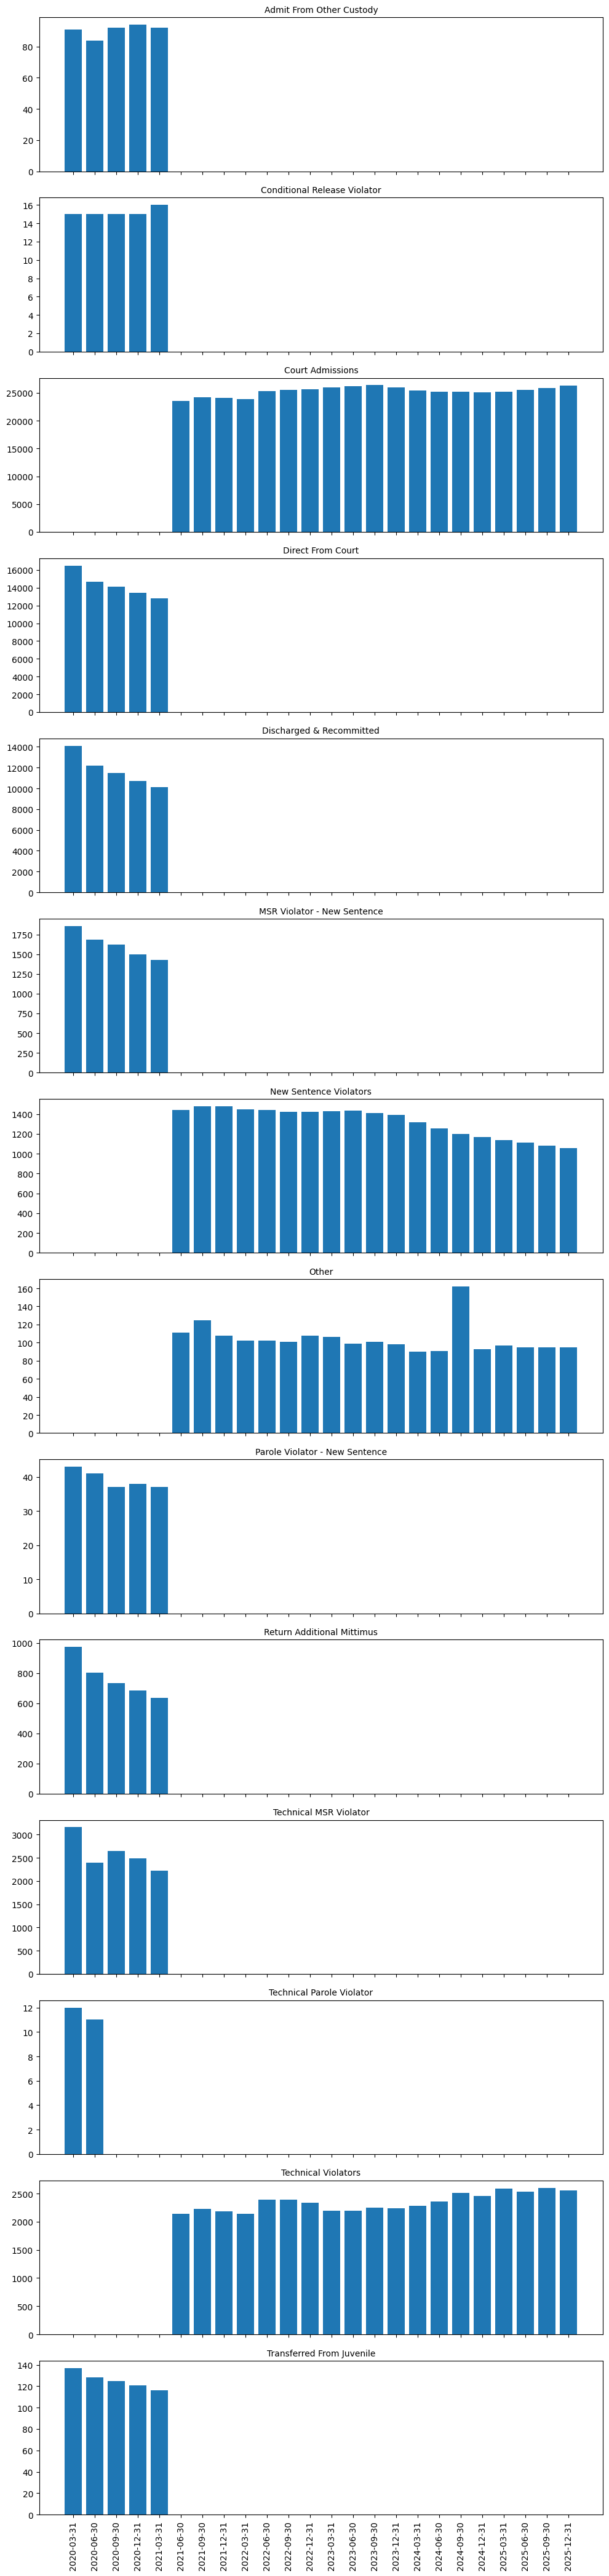

In [49]:

def pick_col(df, candidates=(), patterns=()):
    cols = list(df.columns)
    norm = {c: re.sub(r"\s+", " ", str(c)).strip().lower() for c in cols}

    cand_norm = [re.sub(r"\s+", " ", str(x)).strip().lower() for x in candidates]
    for c in cols:
        if norm[c] in cand_norm:
            return c

    for pat in patterns:
        rx = re.compile(pat)
        for c in cols:
            if rx.search(norm[c]):
                return c

    raise KeyError(
        f"Could not find column.\n"
        f"Candidates: {list(candidates)}\n"
        f"Patterns: {list(patterns)}\n"
        f"Columns (sample): {cols[:40]}{' ...' if len(cols)>40 else ''}"
    )

# --- find the three columns we need ---
doc_col = pick_col(
    df,
    candidates=("Doc Date", "doc_date", "document_date"),
    patterns=(r"(^|_)doc(_| )?date$", r"document(_| )?date", r"\bdoc\b.*\bdate\b"),
)

adm_col = pick_col(
    df,
    candidates=("Admission Type", "admission_type", "Current Admission Type", "current_admission_type"),
    patterns=(r"(^|_)admission(_| )type$", r"\badmission\b.*\btype\b"),
)

idoc_col = pick_col(
    df,
    candidates=("IDOC #", "idoc_#", "idoc", "idoc_no", "idoc_number"),
    patterns=(r"\bidoc\b",),
)

print("Using columns:")
print("  admission =", adm_col)
print("  doc_date  =", doc_col)
print("  idoc      =", idoc_col)

# --- ensure datetime ---
df[doc_col] = pd.to_datetime(df[doc_col], errors="coerce")

# filter recent data (fast, no lambda)
change_df = df[df[doc_col] >= "2020-01-01"]

# group counts by admission type & quarter/doc date
plot_df = (
    change_df
    .groupby([adm_col, doc_col])[idoc_col]
    .count()
    .reset_index(name="count")
)

# keep only meaningful categories
plot_df = plot_df[plot_df["count"] > 10]

# convert dates to strings once for plotting
plot_df["doc_date_str"] = plot_df[doc_col].dt.strftime("%Y-%m-%d")

doc_dates = sorted(plot_df["doc_date_str"].unique())
admission_types = sorted(plot_df[adm_col].dropna().unique())

# plot: one small bar chart per admission type
fig_height = max(3.0 * len(admission_types), 8)
fig, axs = plt.subplots(len(admission_types), figsize=(10, fig_height), sharex=True)

if len(admission_types) == 1:
    axs = [axs]

for i, at in enumerate(admission_types):
    at_df = plot_df[plot_df[adm_col] == at]

    # ensure each date appears (fill missing quarters with 0)
    at_df = (
        pd.DataFrame({"doc_date_str": doc_dates})
        .merge(at_df[["doc_date_str", "count"]], on="doc_date_str", how="left")
        .fillna({"count": 0})
    )

    axs[i].bar(at_df["doc_date_str"], at_df["count"])
    axs[i].set_title(str(at), fontsize=10)
    axs[i].tick_params(axis="x", rotation=90)

plt.tight_layout()
plt.show()


For Jun 2021 going forward, IDOC used different labels.
* Before Jun 2021
    * Direct From Court
    * Admit From Other Custody
    * MSR Violator - New Sentence
    * Parole Violator - New Sentence
    * Discharged & Recommitted
    * Conditional Release Violator
    * Technical MSR Violator
    * Technical Parole Violator
    * Transferred from Juvenile
    * Return Additional Mittimus
    * COVID-19 County Admit
* Jun 2021 forward
    * Court Admissions
    * New Sentence Violators
    * Technical Violators
    * Other

In [50]:
import pandas as pd
import numpy as np
import re
from datetime import date

df = df.copy()

# ---------- helpers ----------
def pick_col(df, candidates=(), patterns=()):
    cols = list(df.columns)
    norm = {c: re.sub(r"\s+", " ", str(c)).strip().lower() for c in cols}

    cand_norm = [re.sub(r"\s+", " ", str(x)).strip().lower() for x in candidates]
    for c in cols:
        if norm[c] in cand_norm:
            return c

    for pat in patterns:
        rx = re.compile(pat)
        for c in cols:
            if rx.search(norm[c]):
                return c
    raise KeyError(f"Could not find column. Columns sample: {cols[:40]}")

doc_col = pick_col(df, candidates=("Doc Date","doc_date"), patterns=(r"(^|_)doc(_| )?date$", r"\bdoc\b.*\bdate\b"))
adm_col = pick_col(df, candidates=("Admission Type","admission_type"), patterns=(r"(^|_)admission(_| )type$", r"\badmission\b.*\btype\b"))
idoc_col = pick_col(df, candidates=("IDOC #","idoc_#","idoc"), patterns=(r"\bidoc\b",))
cad_col  = pick_col(df, candidates=("Current Admission Date","current_admission_date"), patterns=(r"current(_| )admission(_| )date", r"\badmission\b.*\bdate\b"))

print("Using columns:")
print("  doc =", doc_col)
print("  adm =", adm_col)
print("  idoc=", idoc_col)
print("  cad =", cad_col)

# ---------- ensure datetimes ----------
df[doc_col] = pd.to_datetime(df[doc_col], errors="coerce")
df[cad_col] = pd.to_datetime(df[cad_col], errors="coerce")

# ---------- filter window ----------
start = pd.Timestamp("2020-03-01")
end   = pd.Timestamp("2022-09-30")
sankey_df = df.loc[df[doc_col].between(start, end), [idoc_col, cad_col, adm_col, doc_col]].copy()

# drop literal "None" and missing
sankey_df[adm_col] = sankey_df[adm_col].replace("None", np.nan)
sankey_df = sankey_df.dropna(subset=[adm_col, idoc_col, cad_col, doc_col])

# ---------- split periods ----------
cut = pd.Timestamp("2021-06-01")

before = sankey_df[sankey_df[doc_col] < cut].copy()
after  = sankey_df[sankey_df[doc_col] >= cut].copy()

# For each person-admission key, keep the *latest* label within the period
key_cols = [idoc_col, cad_col]

before = (
    before.sort_values(doc_col)
          .drop_duplicates(subset=key_cols, keep="last")
          .rename(columns={adm_col: "Before Admission Type"})
          .drop(columns=[doc_col])
)

after = (
    after.sort_values(doc_col)
         .drop_duplicates(subset=key_cols, keep="last")
         .rename(columns={adm_col: "After Admission Type"})
         .drop(columns=[doc_col])
)

# ---------- recombine ----------
pairs = before.merge(after, on=key_cols, how="outer")

# ---------- count flows ----------
flow_df = (
    pairs.groupby(["Before Admission Type", "After Admission Type"])
         .size()
         .reset_index(name="Count")
)

print(flow_df)

# ---------- nodes ----------
node_df = pd.concat([
    flow_df[["Before Admission Type"]].rename(columns={"Before Admission Type": "AT"}),
    flow_df[["After Admission Type"]].rename(columns={"After Admission Type": "AT"}),
], ignore_index=True).drop_duplicates()

node_df = node_df.reset_index(drop=True).reset_index().rename(columns={"index": "ID"})
node_df["Color"] = get_hex(len(node_df))

# ---------- links ----------
links_df = flow_df.merge(
    node_df[["AT", "ID", "Color"]].rename(columns={"ID": "Source", "Color": "Link Color"}),
    left_on="Before Admission Type",
    right_on="AT",
    how="left",
).merge(
    node_df[["AT", "ID"]].rename(columns={"ID": "Target"}),
    left_on="After Admission Type",
    right_on="AT",
    how="left",
)

# rgba with alpha
links_df["Link Color"] = links_df["Link Color"].apply(lambda x: "rgba" + str(get_rgb_from_hex(x) + (0.5,)))

links_df = links_df[["Source", "Target", "Link Color", "Count"]]

# outputs:
# - flow_df (human-readable flow table)
# - node_df (AT -> ID, Color)
# - links_df (Source/Target/Color/Count)



Using columns:
  doc = doc_date
  adm = admission_type
  idoc= idoc_#
  cad = current_admission_date
             Before Admission Type    After Admission Type  Count
0         Admit From Other Custody        Court Admissions      1
1         Admit From Other Custody                   Other     89
2     Conditional Release Violator                   Other     15
3                Direct From Court        Court Admissions  11844
4         Discharged & Recommitted        Court Admissions   9072
5      MSR Violator - New Sentence  New Sentence Violators   1297
6              Not In IDOC Custody                   Other      1
7   Parole Violator - New Sentence  New Sentence Violators     35
8       Return Additional Mittimus        Court Admissions    546
9                Return To Custody                   Other      1
10          Technical MSR Violator  New Sentence Violators      7
11          Technical MSR Violator     Technical Violators   1429
12       Technical Parole Violator     Te

/var/folders/4s/_j98kgy55mj98s3sfpjstjnh0000gn/T/ipykernel_8019/3527866206.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', n)


In [51]:
import plotly.io as pio
pio.renderers.default = "notebook_connected"

# --- OPTIONAL: reorder nodes so "Before" labels come first, then "After" labels ---
# (Requires flow_df from the Sankey-prep cell)
before_nodes = flow_df["Before Admission Type"].dropna().unique()
after_nodes  = flow_df["After Admission Type"].dropna().unique()
ordered_nodes = list(before_nodes) + [x for x in after_nodes if x not in before_nodes]

node_df = (
    node_df.set_index("AT")
           .loc[ordered_nodes]
           .reset_index()
)

# If you reorder node_df, you MUST remap link Source/Target to the new IDs
node_df["ID"] = range(len(node_df))
id_map = dict(zip(node_df["AT"], node_df["ID"]))

links_df = links_df.copy()
links_df["Source"] = links_df["Source"].map(lambda i: i)  # keep for safety if already ints
links_df["Target"] = links_df["Target"].map(lambda i: i)

# If your links_df Source/Target were built using node_df IDs already, rebuild them from flow_df:
links_df = (
    flow_df.assign(
        Source=flow_df["Before Admission Type"].map(id_map),
        Target=flow_df["After Admission Type"].map(id_map),
    )
    .merge(
        node_df[["AT", "Color"]].rename(columns={"AT": "Before Admission Type", "Color": "Link Color"}),
        on="Before Admission Type",
        how="left",
    )
)

# rgba with alpha (assumes get_rgb_from_hex exists)
links_df["Link Color"] = links_df["Link Color"].apply(lambda x: "rgba" + str(get_rgb_from_hex(x) + (0.5,)))
links_df = links_df[["Source", "Target", "Link Color", "Count"]]

# --- Sankey figure ---
fig = go.Figure(
    data=[
        go.Sankey(
            node=dict(
                pad=35,
                thickness=30,
                line=dict(color="black", width=0),
                label=node_df["AT"].tolist(),
                color=node_df["Color"].tolist(),
            ),
            link=dict(
                source=links_df["Source"].tolist(),
                target=links_df["Target"].tolist(),
                value=links_df["Count"].tolist(),
                color=links_df["Link Color"].tolist(),
            ),
        )
    ]
)

fig.update_layout(
    title=dict(
        text="Change in Admission Type After IDOC Label Revision (June 2021)",
        x=0.5,
    ),
    height=900,
    font_size=12,
)

fig.show()


For the most part, the new admission types group multiple old admission types.
* Court Admissions
    * Direct From Court
    * Discharged & Recommitted
    * Return Additional Mittimus
    * COVID-19 County Admit (but let's keep this as its own since its timeframe is so limited)
    * Transferred From Juvenile
* Other
    * Admit from Other Custody
    * Conditional Release Violator
    * Not In IDOC Custody
    * Return To Custody
* New Sentence Violators
    * MSR Violator - New Sentence
    * Parole Violator - New Sentence
* Technical Violators
    * Technical MSR Violator
    * Technical Parole Violator
    
Let's create a new field with the new admission types grouping the old admission types. Group others (from past quarters) based on similarity to other old admission types.


In [52]:
df = df.copy()

def pick_col(df, candidates=(), patterns=()):
    cols = list(df.columns)
    norm = {c: re.sub(r"\s+", " ", str(c)).strip().lower() for c in cols}

    cand_norm = [re.sub(r"\s+", " ", str(x)).strip().lower() for x in candidates]
    for c in cols:
        if norm[c] in cand_norm:
            return c

    for pat in patterns:
        rx = re.compile(pat)
        for c in cols:
            if rx.search(norm[c]):
                return c

    raise KeyError(f"Could not find Admission Type column. Columns sample: {cols[:40]}")

adm_col = pick_col(
    df,
    candidates=("Admission Type", "admission_type", "Current Admission Type", "current_admission_type"),
    patterns=(r"(^|_)admission(_| )type$", r"\badmission\b.*\btype\b"),
)

print("Using Admission Type column:", adm_col)

ct_admis_list = [
    "Direct From Court",
    "Discharged & Recommitted",
    "Return Additional Mittimus",
    "Transferred From Juvenile",
]
other_list = [
    "Admit From Other Custody",
    "Conditional Release Violator",
    "Not In IDOC Custody",
    "Return To Custody",
    "Work Release Violator",
    "EDV",
    "Juv Parole To Adult Parole",
]
new_sent_viol_list = [
    "MSR Violator - New Sentence",
    "Parole Violator - New Sentence",
    "Conditional Release - New Sentence",
    "Work Release Violator - New Sentence",
]
tech_viol_list = [
    "Technical MSR Violator",
    "Technical Parole Violator",
]

# IMPORTANT: initialize as string dtype (avoids float64 lossy setitem)
df["new_admission_type"] = pd.Series(pd.NA, index=df.index, dtype="string")

# map
df.loc[df[adm_col].isin(ct_admis_list), "new_admission_type"] = "Court Admissions"
df.loc[df[adm_col].isin(other_list), "new_admission_type"] = "Other"
df.loc[df[adm_col].isin(new_sent_viol_list), "new_admission_type"] = "New Sentence Violators"
df.loc[df[adm_col].isin(tech_viol_list), "new_admission_type"] = "Technical Violators"

# fill anything unmapped with original label (cast to string dtype to match)
df["new_admission_type"] = df["new_admission_type"].fillna(df[adm_col].astype("string"))

print(df["new_admission_type"].value_counts(dropna=False).sort_index())

# OPTIONAL: if you want the exact old-style name for downstream code
# df = df.rename(columns={"new_admission_type": "New Admission Type"})





Using Admission Type column: admission_type
new_admission_type
Court Admissions          1807710
New Sentence Violators     157551
Other                        6174
Technical Violators        211918
<NA>                           13
Name: count, dtype: int64[pyarrow]


**Admission Type - Categorization**

Bucket into first-time vs. second-time vs. technical offender. 

Important note: IDOC changed admission labels beginning June 2021 (with additional simplification in later quarters), so the older label-based logic (e.g., matching “Direct From Court”, “MSR Violator – New Sentence”, etc.) does not apply cleanly to the newer categories. Below we implement a version that works across both eras by mapping both pre- and post-change labels into consistent recidivism buckets.


In [53]:
import re
import pandas as pd
import numpy as np

df = df.copy()

def pick_col(df, candidates=(), patterns=()):
    cols = list(df.columns)
    norm = {c: re.sub(r"\s+", " ", str(c)).strip().lower() for c in cols}
    cand_norm = [re.sub(r"\s+", " ", str(x)).strip().lower() for x in candidates]

    for c in cols:
        if norm[c] in cand_norm:
            return c
    for pat in patterns:
        rx = re.compile(pat)
        for c in cols:
            if rx.search(norm[c]):
                return c
    raise KeyError(f"Could not find column. Columns sample: {cols[:40]}")

adm_col = pick_col(
    df,
    candidates=("Admission Type", "admission_type", "New Admission Type", "new_admission_type"),
    patterns=(r"\badmission\b.*\btype\b",),
)

print("Using admission-type column:", adm_col)

s = df[adm_col].astype("string")

# ---- pre-change labels (old) ----
first_old = {
    "Direct From Court",
    "Transferred From Juvenile",
    "Juv Parole To Adult Parole",
}
second_old = {
    "Discharged & Recommitted",
    "MSR Violator - New Sentence",
    "Parole Violator - New Sentence",
    "Work Release Violator - New Sentence",
    "Conditional Release - New Sentence",
    "Conditional Release, New Sentence",
}
technical_old = {
    "Technical Parole Violator",
    "Technical MSR Violator",
    "Conditional Release Violator",
    "Work Release Violator",
}

# ---- post-change labels (new) ----
first_new = {"Court Admissions"}
second_new = {"New Sentence Violators"}
technical_new = {"Technical Violators"}

# initialize as string dtype (no pandas lossy setitem errors)
df["admission_type_recidivism"] = pd.Series(pd.NA, index=df.index, dtype="string")

df.loc[s.isin(first_old | first_new), "admission_type_recidivism"] = "First IDOC Sentence"
df.loc[s.isin(second_old | second_new), "admission_type_recidivism"] = "Second/+ IDOC Sentence"
df.loc[s.isin(technical_old | technical_new), "admission_type_recidivism"] = "Technical MSR/Parole Violator"

# everything else (including "Other") stays unknown unless you want a separate bucket
df["admission_type_recidivism"] = df["admission_type_recidivism"].fillna("Unknown/Uncategorized")

print(df["admission_type_recidivism"].value_counts(dropna=False))




Using admission-type column: admission_type
admission_type_recidivism
First IDOC Sentence              1209744
Second/+ IDOC Sentence            731782
Technical MSR/Parole Violator     212362
Unknown/Uncategorized              29478
Name: count, dtype: int64[pyarrow]


**Holding offenses**

There are a lot of similar but slightly different values here. They need to be bucketed/categorized.
* Some can be bucketed based on the JHA interns' list.
* For the rest, bucket based on keywords found in the holding offense.
    * The order of operations matters. E.g. GUN --> weapon offense must come before POSS --> drug offense, since many weapons offenses include the string POSS.
* There is already a Holding Offense Category field (which is very specific), and an Offense Type field (which is broad), but neither are available before Sep 2021.

In [54]:
# specific holding offenses from interns' list
inj_death_list = ['AB/NEGLECT ELD/DEATH/CAREGIVER', 'AGG BATTERY CHILD <13/GREAT BOD HARM', 'AGG BATTERY OF A CHILD', 'AGG BATTERY W/FIREARM/PERSON', 'AGG BATTERY/CHILD <13/PERM DISABL', 'AGG BATTERY/DISCHARGE FIREARM', 'AGG BATTERY/FIREARM/OFF/FIREMAN', 'AGG BATTERY/GREAT BOD HARM/60+', 'AGG BATTERY/GREAT BOD HARM/FLAME SUBST', 'AGG BATTERY/GREAT BOD HARM/PC OFF', 'AGG BATTERY/GREAT BODILY HARM', 'AGG BATTERY/HARM/PEACE OFFICER', 'AGG BATTERY/MERCHANT', 'AGG BTRY/UNLAWFUL DEL/CON SUB', 'AGG KIDNAPING/INFLICT HARM', 'AGG STALKING/BODILY HARM', 'AGG STALKING/BODILY HARM/2ND', 'AGG VEH HIJACKING/DISCH/HARM', 'AGGRAVATED BATTERY W/FIREARM', 'ARMED ROBBERY/DISCHARGE/HARM', 'DOM BTRY/BOD HARM/4+ PRI CONV', 'DOMESTIC BATTERY/BODILY HARM', 'HEINOUS BATTERY', 'HOME INVASION/CAUSE INJURY', 'HOME INVASION/DISCH FIREARM/HARM', 'INTIMIDATION/PHYSICAL HARM', 'MURDER/2ND DEGREE MURDER', 'MURDER/2ND DEGREE/PROVOCATION', 'MURDER/2ND DEGREE/UNREASON', 'MURDER/HOMICIDE/UNBORN CHILD', 'MURDER/INTENT TO KILL/INJURE', 'MURDER/OTHER FORCIBLE FELONY', 'MURDER/STRONG PROB KILL/INJURE', 'RECKLESS CONDUCT/GREAT BODILY HARM', 'VOLUN MANSL/NEGL-DEATH ANOTHER', 'DRUG INDUCED HOMICIDE', 'AGG DUI BODILY HARM/.10+/CHILD', 'AGG DUI/ACCIDENT/BODILY HARM', 'AGG DUI/ACCIDENT/DEATH', 'AGG DUI/BODILY HARM W/CHILD', 'AGG DUI/DEATH OF ANOTHER', 'AGG DUI/GREAT BODILY HARM', 'INVOL MANSLAUGHTER ATV/BOAT', 'INVOL MANSLAUGHTER FAMILY/BOAT', 'RECKLESS HOMIC/INCLINE/DEATH 2+', 'RECKLESS HOMIC/TRAFFIC CONTROL', 'RECKLESS HOMICIDE', 'RECKLESS HOMICIDE/.08 ALC/DRUG', 'RECKLESS HOMICIDE/ALC/CONVIC', 'RECKLESS HOMICIDE/ALC/DRUG', 'RECKLESS HOMICIDE/KILL 2 INDIV', 'SNOWMB OUI OF ALCOHOL/DEATH', 'INVOL MANSLAUGHTER/FAMILY MEMBER', 'INVOLUNTARY MANSLAUGHTER']
inj_death_unclear_list = ['AGG ASLT PEACE OFF/FIRE/ER WRK', 'AGG ASLT/OP MOTOR VEH/STRUCK', 'AGG ASLT/STATE IL EMP/WEAPON', 'AGG ASSAULT/CORRECTIONAL EMP', 'AGG ASSAULT/DHS EMPLOYEE', 'AGG ASSAULT/DISCH FIREARM MV', 'AGG ASSAULT/OP MOTOR VEH/PC OFF', 'AGG ASSAULT/USE FOREARM/PEACE OFF', 'AGG BATTERY SR CITIZEN >60 YRS', 'AGG BATTERY/CONTROLLED SUB', 'AGG BATTERY/GOVERNMENT EMP', 'AGG BATTERY/INGEST TOXIC SUBST', 'AGG BATTERY/JUDGE/EMT', 'AGG BATTERY/PEACE OFF/FIREMAN', 'AGG BATTERY/PEACE OFFICER', 'AGG BATTERY/PREGNANT/HANDICAPPED', 'AGG BATTERY/PUBLIC PLACE', 'AGG BATTERY/STRANGLE/PREV CONV', 'AGG BATTERY/TRANSIT EMPLOYEE', 'AGG BATTERY/USE DEADLY WEAPON', 'AGG BATTERY/WEAPON/NO FIREARM', 'AGG DISCH FIREARM/PC OFF/FIREMAN', 'AGG DISCH FIREARM/VEH/PC OFF/FRMAN', 'AGG DISCH SILENCER PERSON/VEH', 'AGG DISCHARGE FIREARM/BLDG', 'AGG DISCHARGE FIREARM/OCC BLDG', 'AGG DISCHARGE FIREARM/OCC VEH', 'AGG DOMESTIC BATTERY/STRANGLE', 'AGG INTIMIDATION PEACE OFFICER', 'AGG KIDNAPING ARMED W FIREARM', 'AGG KIDNAPING/CHILD<13/RETARDED', 'AGG KIDNAPING/CONCEAL IDENT', 'AGG ROBBERY/CONTROLLED SUB', 'AGG ROBBERY/INDICATE ARM W/FIR', 'AGG STALKING/VIO REST ORDER', 'AGG VEHICULAR HIJACKING/DISCHARGE', 'AGG VEHICULAR HIJACKING/FIREARM', 'AGG VEHICULAR HIJACKING/HANDICAPPED', 'AGG VEHICULAR HIJACKING/PASS <16 YRS', 'AGG VEHICULAR HIJACKING/WEAPON', 'AGGRAVATED ASSAULT', 'AGGRAVATED BATTERY/NURSE', 'AGGRAVATED BATTERY/STRANGLE', 'AGGRAVATED BATTERY/VICTIM 60+', 'AGGRAVATED DISCHARGE/FIREARM', 'AGGRAVATED DOMESTIC BATTERY', 'AGGRAVATED KIDNAPING/ARMED', 'AGGRAVATED KIDNAPING/RANSOM', 'AGGRAVATED ROBBERY', 'AGGRAVATED TRAFFICKING/BENEFIT', 'AGGRAVATED UNLAWFUL RESTRAINT', 'AGGRAVATED VEHICULAR HIJACKING', 'ARMED ROBBERY', 'ARMED ROBBERY/ARMED W/FIREARM', 'ARMED ROBBERY/DISCH FIREARM', 'ARMED ROBBERY/NO FIREARM', 'ARMED VIOL/CATEGORY I WEAPON', 'ARMED VIOL/CATEGORY II WEAP/1ST', 'ARMED VIOL/CATEGORY II WEAPON', 'ARMED VIOL/CATEGORY III WEAPON', 'CAUSE CHILD/ENDANGERED/2+', 'CHILD ABDUCTN/CONCEAL/DETAIN', 'COMMUNICATE/DETAIN WITNESS', 'CRIM TRES TO RES/PERS PRESENT', 'DISMEMBERING A HUMAN BODY', 'DOM BTRY/CONTACT/3 PRIOR CONV', 'DOMESTIC BATTERY/ CONTACT/PRIOR', 'DOMESTIC BATTERY/PHY CONTACT/2ND+', 'DOMESTIC BATTERY/VIOL PROTECT ORDER', 'GIVE FALSE BOMB/GAS ALARM', 'HABITUAL CRIMINAL/2 PRIOR CL X', 'HARASS JURORS/WITNESSES', 'HARASS WITNESS', 'HARASSMENT BY PHONE/4TH +', 'HOME INVASION', 'HOME INVASION/ARMED W/FIREARM', 'HOME INVASION/ARMED/FORCE', 'HOME INVASION/DANDEROUS WEAP', 'HOME INVASION/DISCH FIREARM', 'HOME INVASION/FIREARM', 'HOME INVASION/SEX OFFENSE', 'HOME INVASION/VIO AGAINST PERS', 'HRSMT/PREVENT/SERV/SAME VIC', 'HRSMT/THREATEN PERSON/KILL', 'HUMAN TRAFFICKING FOR LABOR/BENEFITS', 'INTIMIDATION/CONTEMPT/RIDICULE', 'INTIMIDATION/CRIMINAL OFFENSE', 'INVOL SERVITUDE/THREAT PHYS HARM', 'KIDNAPING ARMED WITH FIREARM', 'KIDNAPING DISCHARGE FIREARM', 'KIDNAPING W FORCE OR THREAT', 'KIDNAPING/SECRETLY CONFINE', 'PHONE HRSMT/LEWD/THREAT KILL', 'RECKLESS DISCH FIREARM/ENDANGERS', 'ROBBERY', 'ROBBERY/SCHOOL/PLACE WORSHIP', 'ROBBERY/VIC HANDICAP / 60+', 'ROBBERY/VIC HANDICAP OR 60+ YR', 'STALKING BY TRANSMITTING THREAT', 'STALKING/PERSON/SURVEILLANCE', 'STALKING/TRANSMITS THREAT/2ND', 'UNLAWFUL RESTRAINT', 'UNLAWFUL VEHICULAR INVASION', 'VEHICULAR HIJACKING', 'VIO ORDER/PRIOR VIO OF ORDER', 'VIOLATE ORDER/PRIOR DOM BATTERY', 'AB/NEGLECT ELDERLY/CAREGIVER', 'ARMED VIOL/CATEGORY II WEAP/2ND+', 'CONTEMPT', 'KIDNAPING/DECEIT OR ENTICE', 'VIOLATE STALKING NO CONTACT/2+', 'CHILD ABDUCT/LURE/VIC<17/PRIOR', 'WINDOW PEEPING 3RD+', 'ATT AGG BATTERY/CHILD <13/PERM DISABL', 'ATT AGG BATTERY/PEACE OFFICER', 'ATT AGG DISCHARGE FIREARM', 'ATT AGG DISCHARGE FIREARM AT VEH', 'ATT AGG DISCHARGE FIREARM OFFICER', 'ATT AGG VEHICLE HIJACK W WEAPON', 'ATT ARMED ROBBERY/ARMED', 'ATT ARMED ROBBERY/NO FIREARM', 'ATT DRUG-INDUCED HOMICIDE', 'ATT HOME INVASION/ARMED W/FIREARM', 'ATT HOME INVASION/FIREARM', 'ATTEMPT AGG BATTERY OF A CHILD', 'ATTEMPT AGG BATTERY/DISCHARGE FIREARM', 'ATTEMPT AGG DISCHARGE/FIREARM', 'ATTEMPT AGG KIDNAPG/CHILD<13/RETARD', 'ATTEMPT AGG KIDNAPING/INFLICT HARM', 'ATTEMPT AGG ROBBERY/INDICATE ARM W/FIR', 'ATTEMPT AGG VEHICULAR HIJACKING', 'ATTEMPT AGGRAVATED ROBBERY', 'ATTEMPT ARMED ROBBERY', 'ATTEMPT ARMED VIO/CATEGORY I WEAPON', 'ATTEMPT DISARM PC OFF/CORR EMP', 'ATTEMPT HARASS JURORS/WITNESSES', 'ATTEMPT HOME INVASION/CAUSE INJURY', 'ATTEMPT INTENT/HOMICIDE/UNBORN CHILD', 'ATTEMPT KIDNAP ARMED W FIREARM', 'ATTEMPT MURDER/INTENT TO KILL/INJURE', 'ATTEMPT MURDER/OTHER FORCIBLE FELONY', 'ATTEMPT MURDER/STRONG PROB KILL/INJURE', 'ATTEMPT ROBBERY', 'ATTEMPT ROBBERY/VIC HANDICAP OR 60+ YR', 'ATTEMPT SOLICITATION/MURDER/FOR HIRE', 'ATTEMPT VEHICULAR HIJACKING', 'CONSP AGGRAVATED ROBBERY', 'CONSP ARMED ROBBERY', 'CONSP MURDER/INTENT TO KILL/INJURE', 'SOLICIT MURDER/INTENT TO KILL/INJURE', 'SOLICITATION ROBBERY', 'SOLICITATION/MURDER', 'SOLICITATION/MURDER/FOR HIRE', 'CONSP ROBBERY', 'ATTEMPT AGG KIDNAP/CONCEAL IDENTITY', 'ATTEMPT KIDNAPING/SECRETLY CONFINE', 'CONSP AGG BATTERY/DISCHARGE FIREARM']
sex_list = ['AGG CHILD PORN/DISSEM FILM', 'AGG CHILD PORN/EXHIBIT', 'AGG CHILD PORN/LEWD EXHIBITION', 'AGG CHILD PORN/PERSON/ANIMAL', 'AGG CHILD PORN/POSS FILM/PHOTO', 'AGG CHILD PORN/POSS FILM/PREV', 'AGG CRIM SEX AB/VIC <18/FAMILY', 'AGG CRIM SEX ABUSE', 'AGG CRIM SEX ABUSE/<5 YR VIC', 'AGG CRIM SEX ABUSE/BODILY HARM', 'AGG CRIM SEX ABUSE/DURING FELONY', 'AGG CRIM SEX ABUSE/FAMILY', 'AGG CRIM SEX ABUSE/FORCE/VIC 9-13', 'AGG CRIM SEX ABUSE/INTELLIG DISABL', 'AGG CRIM SEX ABUSE/VIC <13', 'AGG CRIM SEX ABUSE/VIC 13-16', 'AGG CRIM SEX ABUSE/VIC 13-17', 'AGG CRIM SEX ABUSE/VICTIM <13', 'AGG CRIM SEX ABUSE/VICTIM <9', 'AGG CRIM SEX ASLT/INTEL DISABL', 'AGG CRIM SEX ASLT/THREAT LIFE', 'AGG CRIM SEX ASSAULT/BODILY HARM', 'AGG CRIM SEX ASSAULT/FELONY', 'AGG CRIM SEX ASSAULT/FIREARM', 'AGG CRIM SEX ASSAULT/FORCE VIC9-13', 'AGG CRIM SEX ASSAULT/HANDICAPPED', 'AGG CRIM SEX ASSAULT/RETARDED', 'AGG CRIM SEX ASSAULT/THREAT LIFE', 'AGG CRIM SEX ASSAULT/VIC 60+', 'AGG CRIM SEX ASSAULT/VICTIM <13', 'AGG CRIM SEX ASSAULT/VICTIM <9', 'AGG CRIM SEX ASSAULT/VICTIM >60', 'AGG CRIM SEX ASSAULT/WEAPON', 'AGG CRIM SEXUAL ABUSE/FELONY', 'AGG CRIM SEXUAL ASSAULT/CON SUB', 'AGG CRIM SX AB/VIC 13<18/TRUST', 'AGG CRIM SX ASLT/FORCE VIC9-13', 'AGG IND LIB/CHILD/INFLICT HARM', 'CHILD PORN/FILM/TAPE/PHOTO/ACT', 'CHILD PORN/MOVING DEPICTION', 'CHILD PORN/PERS/ANIM/MOV DPTN', 'CHILD PORN/PERSON/ANIMAL', 'CHILD PORN/POSE/EXHIBITION', 'CHILD PORN/POSS FILM/PHOTOS', 'CHILD PORN/POSS PHOTO/VIC <13', 'CHILD PORN/POSS/MOVING DPTN', 'CHILD PORN/REPRODUCE/MOV DPTN', 'CHILD PORN/REPRODUCE/SELL', 'CHILD PORN/SOL CHILD/MOV DPTN', 'CHILD PORN/SOL/CHILD/APPEAR', 'CHILD PORNOGRAPHY/VICTIM <13', 'CRIM SEX ABUSE/CANT CONSENT/2ND', 'CRIM SEX ASLT/FAM MBR <18/2+', 'CRIM SEX ASLT/FAMILY MEMBER<18', 'CRIM SEX ASLT/FORCE/PREV CONV', 'CRIM SEX ASSAULT/CANT CONSENT', 'CRIM SEX ASSAULT/CANT CONSENT/2ND', 'CRIM SEX ASSAULT/FAMILIES', 'CRIM SEX ASSAULT/FAMILIES/2ND+', 'CRIM SEX ASSAULT/FORCE', 'CRIM SEX ASSAULT/FORCE/2ND+', 'CRIM SEX ASSAULT/SUPERVN VIC 13-17', 'CRIM SEX ASSAULT/VICTIM 13-17', 'CRIM SEX ASSAULT/VICTIM 13-17/2ND', 'CRIM SEXUAL ABUSE/CONSENT', 'CRIM SEXUAL ABUSE/CONSENT/2+', 'CRIMINAL SEX ASSAULT/CONSENT', 'CRIMINAL SEXUAL ABUSE/FORCE', 'DEVIATE SEXUAL ASSAULT', 'GROOMING', 'INDECENT SOL ADULT/<13/PENETRATION', 'INDECENT SOL/AGG CRIM SEX ABUSE', 'INDECENT SOL/CRIM SEX ASSAULT', 'INDECENT SOL/PREDITORY/AGG SEX', 'NONCONSENSUAL  DISSM SEX IMAGE', 'PERMIT SEXUAL ABUSE OF CHILD', 'PRED CRIM SEX ASSLAUT/VICTIM <13', 'PREDATORY CRIM SEX ASSAULT/FIREARM', 'PREDATORY CRIM SEX ASSAULT/HARM', 'PREDATORY CRIMINAL SEXUAL ASSAULT', 'PROM JUV PROST/MINOR <13/RETAR', 'PUBLIC INDECENCY/EXPOSURE/3+', 'RAPE', 'RAPE PRIOR TO 2/1/78', 'SEX RELATIONS WITHIN FAMILIES', 'SEXUALLY DANGEROUS PERSON', 'TRAFFIC SEX SERV MINOR < 17', 'TRAVELING TO MEET A MINOR', 'UNLAWFUL VIDEO/VIC<18/SEX OFF', 'EXPLOIT CHILD/SEX ACT/2ND', 'CUSTODIAL SEXUAL MISCONDUCT', 'INDECENT SOLICIT CHILD/INTERNET', 'ATT AGG CRIM SEX ASSAULT VIC 60+', 'ATT CRIM SEX ASSAULT/FORCE', 'ATT PERMIT SEXUAL ABUSE OF CHILD', 'ATTEMPT AGG CRIM SEX ASLT/BODILY HARM', 'ATTEMPT AGG CRIM SEX ASSAULT', 'ATTEMPT AGG CRIM SEX ASSAULT/BODILY HARM', 'ATTEMPT AGG CRIM SEX ASSAULT/FELONY', 'ATTEMPT AGG CRIM SEX ASSAULT/VICTIM >60', 'ATTEMPT AGG CRIM SEX ASSAULT/WEAPON', 'ATTEMPT AGG CRIM SX AB/>5 YR OLDER VIC', 'ATTEMPT CRIM SEX ASSAULT/FORCE', 'ATTEMPT CRIM SEX ASSAULT/VICTIM 13-17', 'ATTEMPT PRED CRIM SEX ASLT/VICTIM <13', 'ATTEMPT PRED CRIMINAL SEXUAL ASSAULT', 'SOL AGG CRIM SEX ASSAULT/VIC 60+']
drugs_list = ['15<200 OBJECT/PARTS LSD/ANALOG', 'AGG DEL METH PROTECTED <5 GRAMS', 'AGG DEL METH/PROTECTED/100+ GR', 'AGG DEL METH/PROTECTED/5<15 GRAMS', 'AGG METH MANU/ORGANIZE/100<400 GR', 'AGG METH MANU/PROTECTED<15', 'AGG METH MANU/WORSHIP/<15 GR', 'AGG METH MANUF/APT/<15 GRAMS', 'AGG METH MANUF/APT/100<400 GR', 'AGG METH MANUF/CHILD 15<100 GRAMS', 'AGG METH MANUF/CHILD/<15 GRAMS', 'AGG METH MANUF/CHLD/100<400 GRAMS', 'AGG METH MANUF/CHLD/400+ GR', 'AGG METH MANUF/ORGANIZE/<15 GR', 'CALCULATED CRIM DRUG CONSP', 'CALCULATED CRIM DRUG CONSPIR', 'CANNABIS TRAFFICKING', 'CONT SUBS ACT-MANU/DEL', 'CONTROLLED SUB TRAFFICKING', 'CRIM DRUG CONSPIRACY', 'CRIMINAL DRUG CONSPIRACY', 'CRIMINAL DRUG CONSPIRACY >100 GR', 'DEL CONT SUB<18/PARK/SCHOOL/PUB HOUS', 'DEL CONT/COUNT SUB TO <18', 'DEL METH <5 GRAMS', 'DEL/NON NARC SCHED I/II/SC/HS/PARK', 'DISPOSE METH MANUF WASTE', 'MAN/DEL OTHER AMOUNT AMPHETAMINE', 'MANU 5>15 GRAMS ECSTASY', 'MANU/DEL 01-15 GRAMS COCAINE', 'MANU/DEL 1-14 GRAMS HEROIN', 'MANU/DEL 1<15 GRAM FENTANYL', 'MANU/DEL 10-15 GRAMS HEROIN', 'MANU/DEL 10<15 OBJECTS/PARTS LSD', 'MANU/DEL 10>15 PILLS ECSTASY', 'MANU/DEL 100<400 GR FENTANYL', 'MANU/DEL 100<400 GRAMS COCAINE', 'MANU/DEL 100<400 GRAMS HEROIN', 'MANU/DEL 100<400 GRAMS LSD', 'MANU/DEL 100>400 GR ECSTASY', 'MANU/DEL 15/+ GRAMS HEROIN', 'MANU/DEL 15/+GRAMS COCAINE', 'MANU/DEL 15<100 GRAMS COCAINE', 'MANU/DEL 15<100 GRAMS HEROIN', 'MANU/DEL 15<100 GRAMS LSD', 'MANU/DEL 15>100 GR ECSTASY', 'MANU/DEL 15>200 PILLS ECSTASY', 'MANU/DEL 1500+ PILLS ECSTASY', 'MANU/DEL 200+ SCHED I&II', 'MANU/DEL 200+GRAMS METH/AMPH', 'MANU/DEL 200>600 PILLS ECSTASY', 'MANU/DEL 2ND OR SUBQ OFFENSE IN ACT', 'MANU/DEL 3-15 GRAMS LSD', 'MANU/DEL 400<900 GRAMS COCAINE', 'MANU/DEL 400<900 GRAMS METH', 'MANU/DEL 50-200 GRAMS SCHED I&II', 'MANU/DEL 600<1500 OBJECTS/PARTS LSD', 'MANU/DEL 900+ GRAMS COCAINE', 'MANU/DEL 900+ GRAMS ECSTASY', 'MANU/DEL 900+ GRAMS HEROIN', 'MANU/DEL AMT NARC SCHED I/II/SCHOOL/HS/PARK', 'MANU/DEL BARB ACID/SC/PUB HOUS/PARK', 'MANU/DEL CANNABIS/>5,000 GRAMS', 'MANU/DEL CANNABIS/>500 GRAMS', 'MANU/DEL CANNABIS/10-30 GRAMS', 'MANU/DEL CANNABIS/2000<5000 GRAMS', 'MANU/DEL CANNABIS/30-500 GRAMS', 'MANU/DEL COCAINE/SCHOOL/PUB HOUS/PARK', 'MANU/DEL CONT SUBS (PRIOR 1/1/90)', 'MANU/DEL CONT SUBS/ENHANCED', 'MANU/DEL HEROIN/SCHOOL/PUB HOUS/PARK', 'MANU/DEL OTHER AMOUNT SCHEDULE III', 'MANU/DEL OTHER AMOUNT SCHEDULE IV', 'MANU/DEL OTHER AMT METH', 'MANU/DEL OTHER AMT NARC SCHED I&II', 'MANU/DEL OTHER AMT NARCOTIC SCHED I&II', 'MANU/DEL OTHER NON-NARCOTIC SCHED I&II', 'MANU/DEL SCHED I/II/SCH/HS/PARK', 'MANU/DISTRIB LOOK-ALIKE SUB', 'METH CONSP CONT SUBS >100 GR', 'METH DELIVERY/100<400 GR', 'METH DELIVERY/15<100 GRAMS', 'METH DELIVERY/400<900 GR', 'METH DELIVERY/5<15 GRAMS', 'METH DELIVERY/900+ GR', 'METH DELIVERY<5 GRAMS', 'METH MANUFACTURE/100<400 GR', 'METH MANUFACTURE<15 GRAMS', 'METH MANUFACTURING/100<400 GRAMS', 'METH MANUFACTURING/15<100 GR', 'METH MANUFACTURING/15<100 GRAMS', 'METH MANUFACTURING/400<900 GR', 'METH MANUFACTURING/400<900 GRAMS', 'METH MANUFACTURING/900+ GR', 'METH MANUFACTURING<15 GRAMS', 'METH PRECURSOR TRAFFICKING', 'METH PRECURSOR/15<30 GRAMS', 'METH PRECURSOR/500+ GRAMS', 'METH PRECURSOR<15 GRAMS', 'METHAMPHETAMINE CONSPIRACY', 'METHAMPHETAMINE TRAFFICKING', 'MFG/DEL 100<400 GR HERO/ANLG', 'MFG/DEL 15<100 GR FENTANYL', 'MFG/DEL 15<100 GR HEROIN/ANLG', 'MFG/DEL 400<900 GR HERO/ANLG', 'NARCOTICS RACKETEERING', 'OBTAIN SUBSTANCE BY FRAUD/1ST', 'POSS AMT CON SUB EXCEPT(A)/(D)', 'POSS CANNABIS/>5,000 GRAMS', 'POSS CANNABIS/10-30 GRAM/SUBQ', 'POSS CANNABIS/2,000<5,000 GRAMS', 'POSS CANNABIS/500<2,000 GRAMS', 'POSS CONT SUBS', 'POSS HYPO/SYRINGE/NEEDLES/2ND+', 'POSS METH MANUF MATERIAL', 'POSS OF METH < 5 GRAMS', 'POSS OF METH/ 15<100 GRAMS', 'POSSESS 100<400 GRAMS COCAINE', 'POSSESS 100<400 GRAMS HEROIN', 'POSSESS 15+ GRAMS COCAINE', 'POSSESS 15+ GRAMS HEROIN', 'POSSESS 15+ GRAMS MORPHINE', 'POSSESS 15<100 GRAMS COCAINE', 'POSSESS 15<100 GRAMS HEROIN', 'POSSESS 15<100 GRAMS METH', 'POSSESS 15<200 OBJECT/PART LSD', 'POSSESS 15>200 PILLS ECSTASY', 'POSSESS 1500+ PILLS ECSTASY/ANALOG', 'POSSESS 200+ GRAMS OTHER SCHED I&II', 'POSSESS 400<900 GRAMS COCAINE', 'POSSESS 400<900 GRAMS HEROIN', 'POSSESS 900 + GRAMS COCAINE', 'POSSESS 900 + GRAMS HEROIN', 'POSSESSION OF METH/100<400 GRAMS', 'POSSESSION OF METH/15<100 GRAMS', 'POSSESSION OF METH/400<900 GR', 'POSSESSION OF METH/5<15 GRA', 'POSSESSION OF METH/900+ GR', 'POSSESSION OF METH< 5 GRAMS', 'PRODUCE >200 CANNABIS PLANTS', 'TAMPER W/ANHYD AMM EQUIPMENT', 'USE OF DANGEROUS PLACE/CON SUB', 'USE VEH/STRUCTURE/PROP/METH', 'POSS BLANK COUNTERFEIT SCRIPT', 'POSS CANNABIS/30-500 GRAM/1ST', 'MANU/DEL CONT SUBS', 'MANU/DEL 10<30 GRAMS KETAMINE', 'POSS 400>900 GR ECSTASY/ANALOG', 'PRODUCE 5-20 CANNABIS PLANTS', 'ATT MANU 200>600 PILLS ECSTASY', 'ATT METH PRECURSOR/30<150 GR', 'ATTEMPT MANU/DEL 15/+GRAMS COCAINE', 'ATTEMPT MANU/DEL CANNABIS/>500 GRAMS', 'ATTEMPT MANU/DEL OTHER AMT NARC', 'ATTEMPT POSS METH MANUF MATERIAL', 'ATTEMPT POSSESS 15<100 GRAMS COCAINE', 'CONSP MANU/DEL 01-15 GRAMS COCAINE', 'CONSP MANU/DEL OTHER AMOUNT METH', 'CONSP MFG/DEL CANNABIS/>5,000 GRAMS', 'SOLICIT MANU/DEL 01-15 GRAMS COCAINE', 'ATTEMPT MANU/DEL 01-15 GRAMS COCAINE', 'CONSPIRACY METH MANUFACTURE<15 GRAMS', 'ATTEMPT POSS AMT CON SUB', 'CONSP MANU/DEL 15/+GRAMS COCAINE']
property_list = ['AGG ARSON', 'AGG ARSON/INJURE FIRE/POLICE', 'AGG ARSON/KNOW PEOPLE PRESENT', 'AGG HOME FRAUD VIC >60 >%500', 'AGG ID THEFT/<$300/DISABLED', 'AGG ID THEFT/$10,000-$100,000/60 YRS+', 'AGG ID THEFT/$300-10,000/60 YRS +', 'AGG ID THEFT/AGE 60+/2+', 'AGG ID THFT/10K-100K/GANG ACTS', 'AGG ID THFT/ID STOLEN/VIC 60+', 'AGG INSURANCE FRAUD', 'AGGRAVATED ARSON', 'AGGRAVATED ARSON/BODILY HARM', 'AID/ABET/POSS/SELL STOLEN VEH', 'ARSON', 'ARSON/REAL/PERSONAL PROP>$1', 'BAD CHK/OBTAIN CON PROP/>150', 'BURGLARY', 'BURGLARY W/O CAUSING DAMAGE', 'BURGLARY/SCHOOL/PLACE WORSHIP', 'CAUSING A CATASTROPHE', 'CONTINUING FINANCE CRIME ENTRPRS', 'COUNTERFEIT CREDIT/DEBIT CARD', 'CRIM DMG TO PROP $300-10000', 'CRIMINAL DAMAGE $10000-$100000', 'DEFRAUD FINANC INST/$500-$10,000', 'DEFRAUD FINANCIAL INST/>$100K', 'FIN EXPLOIT ELDERLY/70+/$15K+', 'FINANCE EXPLOIT ELD/DISABL/$300-$5,000', 'FINANCIAL INSTITUTION ROBBERY', 'FORGERY /MAKE OR ALTER DOCUMENT', 'FORGERY/ISSUE DOCUMENT/1 UPC', 'FORGERY/ISSUE/DELIVER DOCUMENT', 'FORGERY/POSSESS W INTENT', 'ID THEFT/OBTAIN/3+ INDIV', 'ID THFT/OBTAIN INFO/COMMIT FEL', 'IDENTITY THEFT >$100,000', 'IDENTITY THEFT/<$300', 'IDENTITY THEFT/$10K - $100K', 'IDENTITY THEFT/$2000-$10,000', 'IDENTITY THEFT/$300-$2000', 'IDENTITY THEFT/KNOWS ID STOLEN', 'KNOW ID STOLEN/MILITARY VIC/2+', 'MOB ACTION', 'ORGANIZE/AGG VEH THEFT CONSPIR', 'ORGANIZER/FIN CRIME ENTRPRS', 'POSS STOLEN VEHICLE > $25,000', 'POSSESS BURGLARY TOOLS', 'RECEIVE/POSS/SELL STOLEN VEH', 'RECEIVE/POSS/SELL STOLEN VEHICLE', 'RESIDENTIAL ARSON', 'RESIDENTIAL BURGLARY', 'RET THEFT/DISP MERCH/<$300/PREV CONV', 'RET THEFT/DISP MERCH/>$300', 'RETAIL THEFT/DISP MERCH/<$150/2+', 'RETAIL THEFT/EMERGENCY EXIT/>$300', 'RETAIL THEFT/MOTOR FUEL/>$150', 'THEFT', 'THEFT <$300', 'THEFT <$300 PRIOR', 'THEFT <$300 WITH PRIOR', 'THEFT <$300/PRIOR CONVICT', 'THEFT <$300/SCHOOL/WORSHIP', 'THEFT >$10,000 <$100,000', 'THEFT >$10,000-$100,000', 'THEFT >$100,000-$500,000', 'THEFT >$100,000/SCHOOL/WORSHIP', 'THEFT >$300-$10,000', 'THEFT $300-$10,000/SCHOOL/WORSHIP', 'THEFT $300<$10,000', 'THEFT CONTROL INTENT <$500 PRIOR', 'THEFT CONTROL INTENT $500<$10,000', 'THEFT CONTROL INTENT 10K<100K', 'THEFT CONTROL OF PROPERTY <$500', 'THEFT DECEP INTENT $10,000<$100,000', 'THEFT DECEPTION INTENT 300<10,000', 'THEFT DECEPTION INTENT 500<10000', 'THEFT STOLEN <$300 PRIOR', 'THEFT STOLEN INTENT PERS <$300', 'THEFT STOLEN/>$300 <$10,000', 'THEFT/COIN OP MACHINE/2ND+', 'THEFT/CONTROL INTENT>$500K-1M', 'THEFT/CONTROL/INTENT >$1M', 'THEFT/DECEPTION > $100,000', 'THEFT/DECEPTION >$500,000', 'THEFT/DECEPTION/<$500 PRIOR', 'THEFT/DECEPTION/>$500 <10K', 'THEFT/EMER EXIT/<$300/PRECONV', 'THEFT/STOLEN/ <$500 PRIOR CONV', 'THEFT/STOLEN/>$10,000 <$100,000', 'THEFT/UNAUTHD CONTROL>$300<10000', 'THFT/SWITCH PRICE/<300/PRECONV', 'UNLAWFUL POSS CREDIT/DEBIT CARD', 'UNLAWFUL POSS/DRIVER/VEH/STOLEN', 'UNLAWFUL POSS>3VEH/PARTS/STOLEN', 'USE FORGED CREDIT/DEBIT CARD/>$300', 'VEHICLE THEFT CONSPIRACY', 'FORGE REGISTRATION, ETC', 'ID THEFT/USE ID/COMMIT FELONY', 'IDENTITY THEFT $2,000<$10,000', 'THEFT/FALSE REP/<$300/PRECONV', 'USE OF ACCT NUMBER/CODE/>$150', 'AID/ABET CONCEAL/MISREP VEHICLE', 'RETAIL THEFT/EMERGENCY EXIT/<$300', 'HOME REPAIR FRAUD/CONTRACT >$1,000', 'THFT/LES RTN PROP/<300/PRECONV', 'USE OF ACCT NUMBER/CODE/<$150', 'CRIM DAMAGE PROP>$100,000', 'RET THEFT/MOTOR FUEL/<$150/PREV CONV', 'UNLAWFUL USE ID CARD/THEFT', 'ATT RECEIVE/POSS/SELL STOLEN VEH', 'ATTEMPT AGG ARSON', 'ATTEMPT ARSON', 'ATTEMPT ARSON >$150', 'ATTEMPT BURGLARY', 'ATTEMPT BURGLARY/SCHOOL/PLACE WORSHIP', 'ATTEMPT POSS STOLEN TITLE/CERTIF/PLATE', 'ATTEMPT POSS STOLEN VEHICLE > $25,000', 'ATTEMPT RESIDENTIAL ARSON', 'ATTEMPT RESIDENTIAL BURGLARY', 'ATTEMPT THEFT >$10,000-$100,000', 'CONSP RESIDENTIAL BURGLARY', 'ATTEMPT AID/ABET CONCEAL/MISREP VEHICLE']
weapon_list = ['AGG POSS/11-20 STOLEN FIREARMS', 'AGG POSS/2-5 STOLEN FIREARMS', 'AGG UNLAWFUL USE OF WEAPON/VEH', 'AGG UNLAWFUL USE WEAPON/VEH/2ND', 'AGG UUW/ON PERSON', 'AGG UUW/PERS/FIR LOADED/FOID', 'AGG UUW/PERSON/PREV CONVICTION', 'AGG UUW/VEH/PREV CONVICTION', 'ARMED HABITUAL CRIMINAL', 'FIREARM/AMMO ACT-POSS WO/ID CARD', 'FIREARM/FOID INVALID/NO ELIG', 'GUNRUNNING', 'POSS EXPLOSIVE/INCENDIARY DEVICE', 'POSS FIREARM W/ DEFACED SER NO', 'POSS FIREARM/FOID NO ISSUE/NO ELIG', 'POSS FIREARM/LAND/GANG MEMBER', 'POSS OF FIREARM BY GANG MEMBER', 'POSSESSION OF STOLEN FIREARM', 'UNLAWFUL POSS HANDGUN/DEL/<21', 'UUW-FELON POSS WEAPON/BODY ARMOR', 'UUW-FELON POSS/USE FIREARM PRIOR', 'UUW-FELON POSS/USE FIREARM/PAROLE', 'UUW-FELON POSS/USE WEAPON/FIREARM', 'UUW/CARRY/POSS FIREARM/SCHOOL', 'UUW/MACHINE GUN/AUTO WEAPON/VEH', 'UUW/RIFLE <16 IN/SHOTGUN <18', 'UUW/CARRY/POSS FIREARM/2ND+', 'AGG UUW/PERSON/LOADED FIREARM/2+', 'UUW/CARRY/POSS FIREARM/1ST', 'ATT AGG POSS/31+ STOLEN FIREARMS', 'ATT FELON POSS/USE WEAP/BODY ARMOR', 'ATTEMPT AGG UUW W/ BODY ARMOR/PRIVATE', 'ATTEMPT UUW/FELON POSS/USE FIREARM/PAROLE', 'ATT POSS FIREARM/VEHICLE/GANG MEMBER', 'ATTEMPT POSSESSION OF STOLEN FIREARM']
vehicle_list = ['AGG DUI', 'AGG DUI - SCHOOL BUS DRIVER', 'AGG DUI / 5TH DUI', 'AGG DUI / NO VALID INSURANCE', 'AGG DUI LIC SUSP OR REVOKED', 'AGG DUI/ 4TH /BAC 0.16+', 'AGG DUI/3', 'AGG DUI/3/BAC .16+', 'AGG DUI/3/PASS <16', 'AGG DUI/3RD/LIC SUSP OR REV', 'AGG DUI/3RD+', 'AGG DUI/4', 'AGG DUI/4TH/LIC SUSP OR REVOKED', 'AGG DUI/5/BAC 0.16>', 'AGG DUI/6+', 'AGG DUI/6+/BAC 0.16+', 'AGG DUI/DO DRIVER LICENSE', 'AGG DUI/LIC SUSP OR REVOKED', 'AGG DUI/NO VALID DL', 'AGG DUI/NO VALID INS', 'AGGRAVATED DUI/3RD+ DUI', 'DUI/3RD/BAC 0.16+', 'DUI/4TH+/LIC SUSP OR REVOKE', 'DUI/6TH', 'AGG DUI NO VALID DRIVERS LICENSE', 'AGG DUI/3RD+ DUI', 'DRIV LIC REVOKED/RECK HOMIC/2', 'DRIVE REVOKED/RECK HOMIC', 'DRIVE REVOKED/RECKL HOMIC/3', 'DRIVE W REVOKED/RECK HOMIC/4+', 'DRIVING RVK/SUSP DUI/SSS 4-9', 'DRIVING W/ REVOKE/SUSPEND LICENSE 2ND+', 'DRIVING W/ SUSPEND/REVOKE LICENSE 10-14', 'DRIVING W/ SUSPEND/REVOKE LICENSE 15+', 'DRIVING W/ SUSPEND/REVOKE LICENSE 2ND', 'DRIVING W/ SUSPEND/REVOKE LICENSE 3RD', 'DRIVING W/ SUSPEND/REVOKE LICENSE 4-9', 'REVOKED/SUSPENDED 2ND DUI']
registry_list = ['VIOLENT OFF/YOUTH FAIL REGIS NEW RESID/SCHOOL', 'VIOLENT OFF/YOUTH FAIL REGIS/FAIL TO REPORT', 'VIOLENT OFF/YOUTH FAIL REGISTER IN ILLINOIS', 'VIOLENT OFF/YOUTH FAIL REGIS IN ILLINOIS 2+', 'CHIL SEX OFFEN/RESIDE SAY CARE', 'CHILD SEX OFFENDER/PUBLIC PARK', 'CHILD SEX OFFENDER/RESIDE 500FT', 'FAIL REGIS/NEW REDIS/SCH/2ND+', 'FAIL TO REPORT ANNUALLY/2+', 'SEX OFF FAIL REGISTER NEW RESIDENCE', 'SEX OFF FAIL REPORT CHANGE ADDR/EMPL', 'SEX OFF FAIL REPORT CHANGE ADDRESS/EMPLOY', 'SEX OFF FAIL TO REPORT ANNUALLY', 'SEX OFF FAIL TO REPORT WEEKLY/2ND', 'SEX OFFENDER AT PUBLIC PARK', 'SEX OFFENDER GIVE FALSE INFO/2ND', 'SEX OFFENDER REGIS VIOLATION', 'SEX OFFENDER REGIS/FALSE INFO', 'SEX VIOL/DANGEROUS FAIL TO RPT', 'PHOTO/DIGITAL IMAGE OF CHILD BY SEX OFFENDER', 'ATT SEX OFF FAIL REPORT/NO ADDR/2', 'ATT VIOL SEX OFFENDER REGIS ACT']
other_list = ['AGG FLEEING POLICE/21 MPH OVER', 'AGG FLEEING POLICE/2ND', 'AGG FLEEING/2+ CON DVC/2ND', 'AGG FLEEING/2+ DISOBEY TRAFFIC DEVICES', 'AGG FLEEING/21 MPH OVER/2ND', 'AGG FLEEING/DAMAGE >$300 PROPERTY', 'BRIBERY/OFFER BRIBE', 'BRING CANNABIS IN A PENAL INST', 'BRING CON SUBSTANCE PENAL INST', 'BRING TOOL IN A PENAL INSTITUTION', 'BRING/POSS CONTRAB IN PENAL INST', 'CAUSE/BRG CON SUB PENAL INST', 'CONCEAL HOMICIDAL DEATH', 'CONCEAL/AID FUGITIVE', 'CONSP AGAINST CIVIL RIGHTS', 'DISARM PC OFF/CORR INST EMP', 'DISARMING A PEACE OFFICER', 'ESCAPE FROM DEPT OF CORRECTION', 'ESCAPE OF FELON FROM PENAL INST', 'ESCAPE/VIOLATE ELEC MONITORING', 'FAIL REPORT ACCIDENT/DEATH/INJURY', 'FAILURE REPORT ACCIDENT/DEATH', 'FAILURE REPORT ACCIDENT/INJURY', 'FALSE ALARM/COMPLAINT TO 911', 'FALSE PERSONATION OF POLICE', 'FALSE REPORT OF OFFENSE', 'FELON ESCAPE/PEACE OFFICER', 'FELON FAIL TO RETURN FROM FURLOUGH', 'FELON PROBATIONER ESCAPE OFF', 'FLEEING/ATTEMPT ELUDE OFF 3+', 'INDIRECT CRIMINAL CONTEMPT', 'MANUF/POSS ADULTERANTS DRUG TEST', 'MONEY LAUNDERING >$500,000', 'OBSTRUCT JUST/DESTROY EVIDENCE', 'OBSTRUCTING JUSTICE', 'POSS CONTROL SUBST PENAL INST', 'POSS CONTROL SUBSTANCE IN PENAL INST', 'POSS FRAUDULENT ID CARD', 'POSS/FRAUD/DL/PERMIT', 'POSSESS CANNIBIS PENAL INST', 'POSSESS ELEC CONTRABAND PENAL INST', 'POSSESS WEAPON IN PENAL INST', 'RESIST/OBSTRUC OFFICER/INJURY', 'RICO ACQUIRE ENTERPRISE', 'RICO CONSPIRACY TO VIOLATE', 'TERRORISM/FALSE THREAT', 'THREATEN PUBLIC OFFICIAL', 'THREATEN PUBLIC OFFICIAL/2ND', 'UUW-FELON POSS WEAPON IN PRISON', 'VENDOR FRAUD/KICKBACKS VIOL', 'CRIM DAMAGE/GOVT PROP/EXPL/<$500', 'CRIM DMG/GOVT PROP/<$500', 'CRIM DMG/GOVT PROP/>$500-$10K', 'RESIST/OBSTRUCT OFFICER/INJURY', 'UUW-FELON POSS/USE WEAP/PRISON', 'CRIM DAMAGE/STATE PROP/FIRE>$100,000', 'POSS/DISP ID CARD TO ANOTHER', 'ATT FOIL/DEFEAT SCREEN TEST', 'ATTEMPT ESCAPE FELON FROM PENAL INST', 'AGGRAVATED CRUELTY TO ANIMALS', 'ANIMAL TORTURE/2ND', 'CRUELTY TO ANIMALS/2ND', 'DOG FIGHTING/ATTEND SHOW']

# ---------------- helpers ----------------
def pick_col(df, candidates=(), patterns=()):
    cols = list(df.columns)
    norm = {c: re.sub(r"\s+", " ", str(c)).strip().lower() for c in cols}
    cand_norm = [re.sub(r"\s+", " ", str(x)).strip().lower() for x in candidates]

    for c in cols:
        if norm[c] in cand_norm:
            return c
    for pat in patterns:
        rx = re.compile(pat)
        for c in cols:
            if rx.search(norm[c]):
                return c
    raise KeyError(f"Could not find column. Columns sample: {cols[:40]}")

hold_col = pick_col(
    df,
    candidates=("Holding Offense", "holding_offense"),
    patterns=(r"\bholding\b.*\boffense\b",),
)

# optional (if present) — not needed for categorization, but you were printing them
hoc_col = None
try:
    hoc_col = pick_col(df, candidates=("Holding Offense Category", "holding_offense_category"),
                       patterns=(r"\bholding\b.*\bcategory\b",))
except KeyError:
    pass

ot_col = None
try:
    ot_col = pick_col(df, candidates=("Offense Type", "offense_type"),
                      patterns=(r"(^|_)offense(_| )type$",))
except KeyError:
    pass

print("Using columns:")
print("  holding offense:", hold_col)
if hoc_col: print("  existing holding category:", hoc_col)
if ot_col:  print("  existing offense type:", ot_col)

# ---------------- quick diagnostics (like your prints) ----------------
if hoc_col:
    print(df[hoc_col].value_counts(dropna=False))
if ot_col:
    print(df[ot_col].value_counts(dropna=False))

len1 = len(df)

# normalize holding offense text
df[hold_col] = df[hold_col].astype("string").str.strip()

# initialize output column with string dtype (IMPORTANT)
cat_col = "holding_offense_cat"
df[cat_col] = pd.Series(pd.NA, index=df.index, dtype="string")

# ---------------- interns lists (your exact lists) ----------------
# (I’m assuming you've defined inj_death_list, inj_death_unclear_list, sex_list, drugs_list,
#  property_list, weapon_list, vehicle_list, registry_list, other_list above in the notebook.)a

df.loc[df[hold_col].isin(inj_death_list),          cat_col] = "Person - Death/Physical Injury"
df.loc[df[hold_col].isin(inj_death_unclear_list),  cat_col] = "Person - Death/Physical Injury Unclear"
df.loc[df[hold_col].isin(sex_list),                cat_col] = "Sex"
df.loc[df[hold_col].isin(drugs_list),              cat_col] = "Drugs"
df.loc[df[hold_col].isin(property_list),           cat_col] = "Property"
df.loc[df[hold_col].isin(weapon_list),             cat_col] = "Firearms/Weapon"
df.loc[df[hold_col].isin(vehicle_list),            cat_col] = "DUI/Vehicle Violation Without Death/Physical Injury"
df.loc[df[hold_col].isin(registry_list),           cat_col] = "Sex Offender/MVOAY Registry Violation"
df.loc[df[hold_col].isin(other_list),              cat_col] = "State/Other"

# ---------------- keyword fallback rules (ORDERED!) ----------------
# IMPORTANT: order matters (weapons before POSS/drugs)
keyword_rules = [
    # registry should come before generic sex terms
    ("Sex Offender/MVOAY Registry Violation", r"SEX\s*OFF|REGIS|REGISTER"),

    # sex
    ("Sex", r"PORN|RAPE|SEX|INDEC|SOLICIT|PROST"),

    # homicide/serious harm first
    ("Person - Death/Physical Injury", r"MURDER|HOMIC|HOMICIDE|MANSLAU|MANS\b|KILL|DEATH|HEINOUS"),

    # ambiguous person-violence
    ("Person - Death/Physical Injury Unclear", r"ASSAULT|BATTERY|HARM|KIDNAP|ABD|ENDANGER|STALK|ROBBERY|HOME INVASION"),

    # weapons BEFORE drug possession
    ("Firearms/Weapon", r"GUN|WEAP|FIREA|FIREARM|AMMO|DISCH|UUW|ARMED|HANDGUN|RIFLE|SHOTGUN"),

    # property
    ("Property", r"THEFT|STOL|BURGL|ROBB|ARSON|FORGER|FRAUD|ID THEFT|DAMAGE|DMG|VEH THEFT|RETAIL"),

    # vehicle/DUI
    ("DUI/Vehicle Violation Without Death/Physical Injury", r"\bDUI\b|DRIV|REVOK|SUSPEN|LICENSE|TRAFFIC"),

    # drugs last-ish
    ("Drugs", r"DRUG|METH|HEROIN|COCAINE|FENT|CANNAB|ECSTASY|LSD|NARC|CONT SUB|DEL\b|MANU|POSS"),
]

# apply keyword rules only where still missing
for label, pat in keyword_rules:
    mask = df[cat_col].isna() & df[hold_col].str.contains(pat, case=False, na=False, regex=True)
    df.loc[mask, cat_col] = label

# anything still missing -> other
df[cat_col] = df[cat_col].fillna("State/Other")

# length should not change
if len(df) != len1:
    raise RuntimeError("ERROR: categorizing offenses changed the df length")

print(df[cat_col].value_counts(dropna=False))

# OPTIONAL: if you need the old exact column name for downstream code
# df = df.rename(columns={cat_col: "Holding Offense Cat"})




Using columns:
  holding offense: holding_offense
  existing holding category: holding_offense_category
  existing offense type: offense_type
holding_offense_category
NaN                             1615168
Homicide                         147880
Sex Assault After 7-84            81413
Weapons                           68775
Assault-Battery-Force-Harm        66551
Control Substance Viol            55932
Armed Robbery                     28902
Burglary                          13986
Residential Burglary              13454
DUI-Liquor                        13185
Other Sex Offenses                13095
Robbery                           11610
Motor Veh Theft                    7499
Kidnapping                         5645
Home-Veh Invasion                  4801
Retail Theft                       4562
Theft                              4232
Motor Veh Offenses                 3934
Armed Violence                     3900
Escape or Aid                      3550
Forgery-Deception-Fraud          

In [55]:
import plotly.graph_objects as go

pio.renderers.default = "browser"

df = df.copy()

def pick_col(df, candidates=(), patterns=()):
    cols = list(df.columns)
    norm = {c: re.sub(r"\s+", " ", str(c)).strip().lower() for c in cols}
    cand_norm = [re.sub(r"\s+", " ", str(x)).strip().lower() for x in candidates]

    for c in cols:
        if norm[c] in cand_norm:
            return c
    for pat in patterns:
        rx = re.compile(pat)
        for c in cols:
            if rx.search(norm[c]):
                return c
    raise KeyError(f"Could not find column. Columns sample: {cols[:40]}")

hold_cat_col = pick_col(
    df,
    candidates=("Holding Offense Cat", "holding_offense_cat", "Holding Offense Category", "holding_offense_category"),
    patterns=(r"\bholding\b.*\b(offense)?\b.*\bcat", r"\bholding\b.*\bcategory\b"),
)

off_type_col = pick_col(
    df,
    candidates=("Offense Type", "offense_type"),
    patterns=(r"(^|_)offense(_| )type$",),
)

idoc_col = pick_col(
    df,
    candidates=("IDOC #", "idoc_#", "idoc"),
    patterns=(r"\bidoc\b",),
)

cad_col = None
try:
    cad_col = pick_col(
        df,
        candidates=("Current Admission Date", "current_admission_date"),
        patterns=(r"current(_| )admission(_| )date",),
    )
except KeyError:
    pass

print("Using columns:")
print("  holding_cat:", hold_cat_col)
print("  offense_type:", off_type_col)
print("  idoc:", idoc_col)
if cad_col:
    print("  current_admission_date:", cad_col)

# ---------- prep flows ----------
use_cols = [hold_cat_col, off_type_col, idoc_col]
if cad_col:
    use_cols.append(cad_col)

holding_sankey_df = df[use_cols].drop_duplicates()

flow_df = (
    holding_sankey_df
    .groupby([hold_cat_col, off_type_col])[idoc_col]
    .count()
    .reset_index(name="Count")
)

print(flow_df)

# ---------- nodes ----------
node_df = pd.concat([
    flow_df[[hold_cat_col]].rename(columns={hold_cat_col: "AT"}),
    flow_df[[off_type_col]].rename(columns={off_type_col: "AT"}),
], ignore_index=True).drop_duplicates()

node_df = node_df.reset_index(drop=True).reset_index().rename(columns={"index": "ID"})
node_df["Color"] = get_hex(len(node_df))

# ---------- links ----------
links_df = (
    flow_df
    .merge(
        node_df[["AT", "ID", "Color"]].rename(columns={"ID": "Source", "Color": "Link Color"}),
        left_on=hold_cat_col,
        right_on="AT",
        how="left",
    )
    .merge(
        node_df[["AT", "ID"]].rename(columns={"ID": "Target"}),
        left_on=off_type_col,
        right_on="AT",
        how="left",
    )
)

links_df["Link Color"] = links_df["Link Color"].apply(lambda x: "rgba" + str(get_rgb_from_hex(x) + (0.5,)))
links_df = links_df[["Source", "Target", "Link Color", "Count"]]

# ---------- chart ----------
fig = go.Figure(
    data=[
        go.Sankey(
            node=dict(
                pad=20,
                thickness=30,
                line=dict(color="black", width=0),
                label=node_df["AT"].tolist(),
                color=node_df["Color"].tolist(),
            ),
            link=dict(
                source=links_df["Source"].tolist(),
                target=links_df["Target"].tolist(),
                value=links_df["Count"].tolist(),
                color=links_df["Link Color"].tolist(),
            ),
        )
    ]
)

fig.update_layout(
    title_text="Difference between Phil's Categories and IDOC Offense Type",
    height=1000,
    font_size=12,
)

fig.show()


Using columns:
  holding_cat: holding_offense_category
  offense_type: offense_type
  idoc: idoc_#
  current_admission_date: current_admission_date
        holding_offense_category     offense_type  Count
0                  Armed Robbery    Person Crimes   5745
1                 Armed Violence    Person Crimes    598
2                          Arson    Person Crimes    192
3                          Arson  Property Crimes    458
4     Assault-Battery-Force-Harm    Person Crimes  16196
5                 Bail Bond Viol     Other Crimes     18
6                       Burglary  Property Crimes   5151
7                       Cannabis      Drug Crimes    822
8         Control Substance Viol      Drug Crimes  18990
9   Crim Trespass/Damage to Prop  Property Crimes    897
10                    DUI-Liquor      Drug Crimes   3484
11                    DUI-Liquor    Person Crimes    379
12            Disorderly Conduct     Other Crimes    214
13                 Escape or Aid     Other Crimes    6

/var/folders/4s/_j98kgy55mj98s3sfpjstjnh0000gn/T/ipykernel_8019/3527866206.py:6: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



Phil's categories match pretty well with IDOC's.

**Recidivism calculation**

IDOC changed the way that it records recidivism over the years. Recalculate recidivism as sentence number.

In [56]:

def pick_col(df, candidates=(), patterns=()):
    cols = list(df.columns)
    norm = {c: re.sub(r"\s+", " ", str(c)).strip().lower() for c in cols}
    cand_norm = [re.sub(r"\s+", " ", str(x)).strip().lower() for x in candidates]
    for c in cols:
        if norm[c] in cand_norm:
            return c
    for pat in patterns:
        rx = re.compile(pat)
        for c in cols:
            if rx.search(norm[c]):
                return c
    raise KeyError(f"Could not find column. Columns sample: {cols[:40]}")

idoc_col = pick_col(
    df,
    candidates=("IDOC #", "idoc_#", "idoc", "idoc_number", "idoc_no"),
    patterns=(r"\bidoc\b",),
)

admit_col = pick_col(
    df,
    candidates=("Current Admission Date", "current_admission_date", "admission_date"),
    patterns=(r"current(_| )admission(_| )date", r"\badmission\b.*\bdate\b"),
)

print("Using columns:")
print("  idoc :", idoc_col)
print("  admit:", admit_col)

len1 = len(df)

# convert admission date to datetime
df[admit_col] = pd.to_datetime(df[admit_col], errors="coerce")

# build a per-person admission table (unique admission events)
df_admis = df[[idoc_col, admit_col]].drop_duplicates()

# IMPORTANT: decide how to treat missing admission dates
# Option A (recommended): keep them, but sentence_number will be NA
# Option B: drop missing admission dates entirely
# df_admis = df_admis.dropna(subset=[admit_col])

# assign sentence number as dense order of admission dates within person
df_admis = df_admis.sort_values([idoc_col, admit_col])
df_admis["Sentence Number"] = (
    df_admis.groupby(idoc_col)[admit_col]
            .rank(method="dense", ascending=True)
            .astype("Int64")   # nullable int
)

# merge back
df = df.merge(df_admis, on=[idoc_col, admit_col], how="left")

if len(df) != len1:
    print("len(df) =", len(df))
    print("len1    =", len1)
    raise RuntimeError("ERROR: Adding the sentence number changed the df length")

df["Sentence Number"].value_counts(dropna=False).sort_index()




Using columns:
  idoc : idoc_#
  admit: current_admission_date


Sentence Number
1       1147282
2        285819
3        136466
4         59578
5         24400
6          9846
7          3912
8          1536
9           601
10          167
11           52
12           10
13            9
14            4
15            3
16            1
17            1
18            1
<NA>     513678
Name: count, dtype: Int64

**Eligibility for Sentencing Credits**

For the purposes of our analysis, someone is *ineligible* for earned discretionary sentencing credits (EDSC) if:
* Their holding offense is related to gunrunning or sex
* They're sentenced to life
* They're required to serve at least 85% of their sentence under truth-in-sentencing
* They're considered a sexually dangerous person (SDP)

Otherwise, they are eligible.

In [57]:
def pick_col(df, candidates=(), patterns=()):
    cols = list(df.columns)
    norm = {c: re.sub(r"\s+", " ", str(c)).strip().lower() for c in cols}
    cand_norm = [re.sub(r"\s+", " ", str(x)).strip().lower() for x in candidates]
    for c in cols:
        if norm[c] in cand_norm:
            return c
    for pat in patterns:
        rx = re.compile(pat)
        for c in cols:
            if rx.search(norm[c]):
                return c
    raise KeyError(f"Could not find column. Columns sample: {cols[:40]}")

tis_col = pick_col(df, candidates=("TIS Pct", "tis_pct"), patterns=(r"\btis\b", r"truth.*sentenc"))
hold_col = pick_col(df, candidates=("Holding Offense", "holding_offense"), patterns=(r"\bholding\b.*\boffense\b",))
sent_years_col = pick_col(df, candidates=("Sentence Years", "sentence_years"), patterns=(r"\bsentence\b.*\byears\b",))
hold_cat_col = pick_col(df, candidates=("Holding Offense Cat", "holding_offense_cat"), patterns=(r"\bholding\b.*\bcat", r"\bholding\b.*\bcategory\b"))

print("Using columns:")
print("  tis_pct      =", tis_col)
print("  holding_off  =", hold_col)
print("  sentence_yrs =", sent_years_col)
print("  holding_cat  =", hold_cat_col)

# --- clean types ---
df[tis_col] = pd.to_numeric(df[tis_col], errors="coerce")
holding_upper = df[hold_col].astype("string").str.upper()
sent_years_upper = df[sent_years_col].astype("string").str.upper()
hold_cat = df[hold_cat_col].astype("string")

# --- build ineligible mask ---
ineligible = (
    (df[tis_col] >= 0.85) |
    holding_upper.str.contains("GUNRUNNING", na=False) |
    sent_years_upper.isin(["LIFE", "SDP"]) |
    (hold_cat == "Sex")
)

# --- assign eligibility with proper dtype ---
df["edsc_eligible"] = pd.Series(pd.NA, index=df.index, dtype="string")
df.loc[ineligible, "edsc_eligible"] = "N"
df["edsc_eligible"] = df["edsc_eligible"].fillna("Y")

print(df["edsc_eligible"].value_counts(dropna=False))

df = df.rename(columns={"edsc_eligible": "EDSC Eligible"})

print(df['EDSC Eligible'].value_counts())



Using columns:
  tis_pct      = tis_pct
  holding_off  = holding_offense
  sentence_yrs = sentence_years
  holding_cat  = holding_offense_cat
edsc_eligible
Y    1407531
N     775835
Name: count, dtype: int64[pyarrow]
EDSC Eligible
Y    1407531
N     775835
Name: count, dtype: int64[pyarrow]


**Exporting the data**

The full data set is 1.8 million records. Export with understanding.

UPDATED: As of February 11, 2026, the dataset is 2.1 million records. 

In [58]:
print(len(df))

2183366


In [59]:
# export more recent data
# df_recent = df[df['Doc Date'] >= date(2014, 1, 1)]
# print(len(df_recent))
# df_recent.to_csv('pop_data_2014_thru_20220331.csv')

# # export single institution all time
# df_export = df[df['Parent Institution'] == 'Logan']
# print(len(df_export))


In [60]:
# df_recent.to_csv('pop_data_20140101-20211231.csv')
df.to_csv('pop_data_thru_20260211.csv')

In [61]:
df = df.rename(columns={
    "IDOC #": "idoc_#",   # if it still exists anywhere
    "New Admission Type": "new_admission_type_old",
    "Admission Type - Recidivism": "admission_type_recidivism_old",
    "EDSC Eligible": "edsc_eligible"
})

# ---- DROP DUPLICATES ----
cols_to_drop = [
    "new_admission_type_old",
    "admission_type_recidivism_old"
]

df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])
print(df.columns.tolist())


front = [
    "idoc_#",
    "doc_date",
    "current_admission_date",
    "sentence_date",
    "Sentence Number"
]

remaining = [c for c in df.columns if c not in front]

df = df[front + remaining]

['idoc_#', 'name', 'date_of_birth', 'sex', 'race', 'veteran_status', 'current_admission_date', 'admission_type', 'parent_institution', 'projected_mandatory_supervised_release_(msr)_date', 'projected_discharge_date', 'custody_date', 'sentence_date', 'crime_class', 'holding_offense', 'holding_offense_category', 'offense_type', 'sentence_years', 'sentence_months', 'truth_in_sentencing', 'sentencing_county', 'sentencing_region', 'doc_date', 'tis_pct', 'tis_desc', 'sentence_years_raw', 'sentence_months_raw', 'sentence_years_int', 'sentence_months_int', 'sentence_total_months', 'sentence_years_cont', 'sentence_years_label', 'projected_discharge_date_capped', 'projected_mandatory_supervised_release_(msr)_date_capped', 'age', 'age_at_custody', 'projected_release_date_capped', 'projected_age_at_release_capped', 'projected_time_until_release_capped', 'ID', 'Last Doc Date', 'new_admission_type', 'admission_type_recidivism', 'holding_offense_cat', 'Sentence Number', 'edsc_eligible']


In [67]:
#converting object columns bc Tableau was having trouble with them, 

df["admission_type"] = df["admission_type"].astype("string")
df = df.convert_dtypes()
df.dtypes


idoc_#                                                              string
doc_date                                                    datetime64[us]
current_admission_date                                      datetime64[us]
sentence_date                                               datetime64[us]
Sentence Number                                                      Int64
name                                                                string
date_of_birth                                               datetime64[us]
sex                                                               category
race                                                              category
veteran_status                                                    category
admission_type                                                      string
parent_institution                                                category
projected_mandatory_supervised_release_(msr)_date           datetime64[us]
projected_discharge_date 

In [69]:
df.to_parquet("final_clean_idoc.parquet", index=False)
df.to_csv("final_clean_idoc_for_analysis.csv", index=False)